In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime
import matplotlib.pyplot as plt

In [8]:

#models for prophet predict
def prophetmodel(data: pd.DataFrame) -> list:
    """
    get prediction by using fbprophet
    :param data:  Dataframe - data with two columns date and y
    :return:      Dateframe - predict result
    """
    #the format cannot be chagne
    subset = pd.DataFrame({
        'ds': data.date,
        'y': data.iloc[:,1],
    })
    
    #define model parameters
    m = Prophet(
        changepoint_prior_scale=0.05, 
        daily_seasonality=False, #since we are using daily data
        weekly_seasonality=True,
        yearly_seasonality=True,
        growth='linear',
    )
    
    m.add_country_holidays(country_name = "US") #added extra variables, like holiday
    
    m.fit(subset) #fit the model
    
    #predict for the next 28 days, frequency is daily
    future = m.make_future_dataframe(periods=28, freq='D')

    forecast = m.predict(future)
    
    #plot the forecast
    fig1 = m.plot(forecast)
    
    return forecast

In [9]:
data = pd.read_csv('/Users/yingding/Desktop/Forcasting M2/Project and data-20220107/Projectdata.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')  #convert date into datetime
test = data.tail(394)     #train test split
train = data.iloc[:-394,:]

In [10]:
print(train.shape)
print(test.shape)

(1575, 19)
(394, 19)


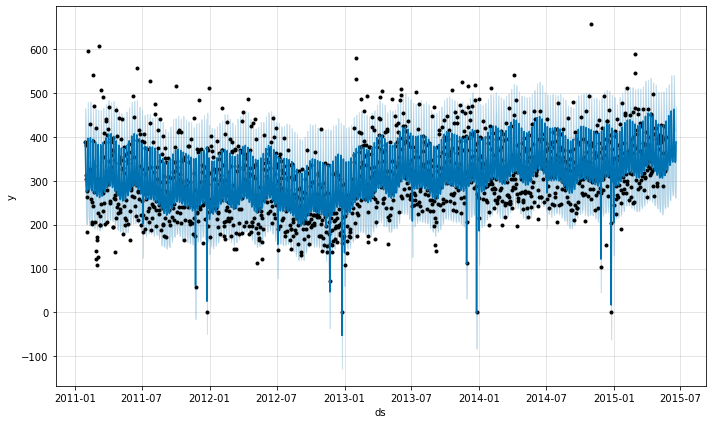

In [11]:
#try model with one variables
predict_data = train.iloc[:, [0,1]]
result = prophetmodel(predict_data)

In [12]:
len(train.columns)

19

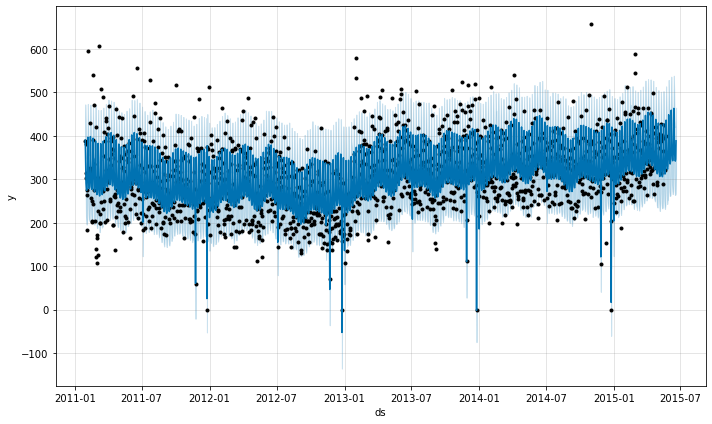

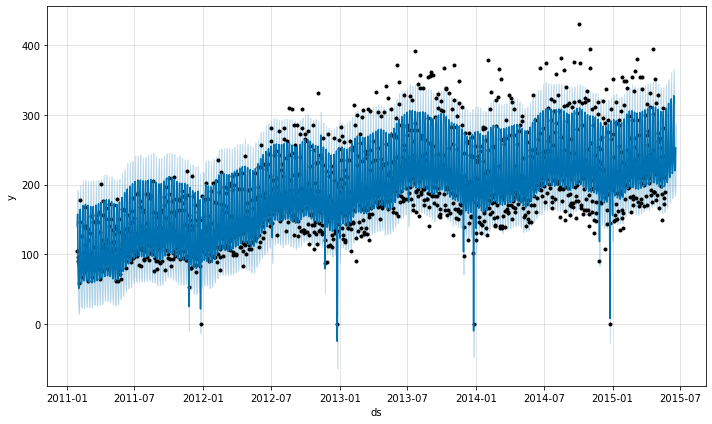

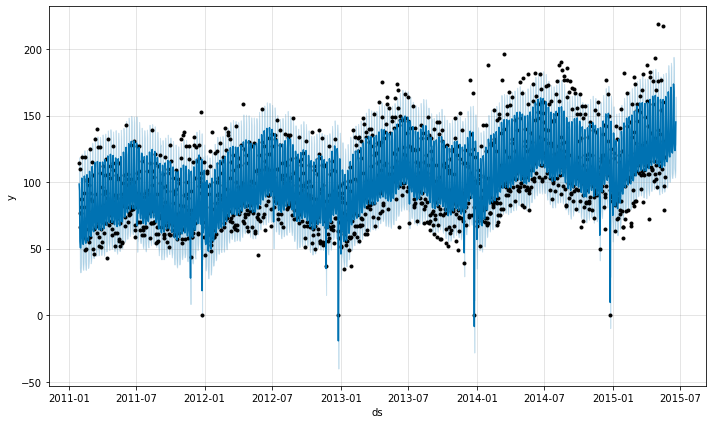

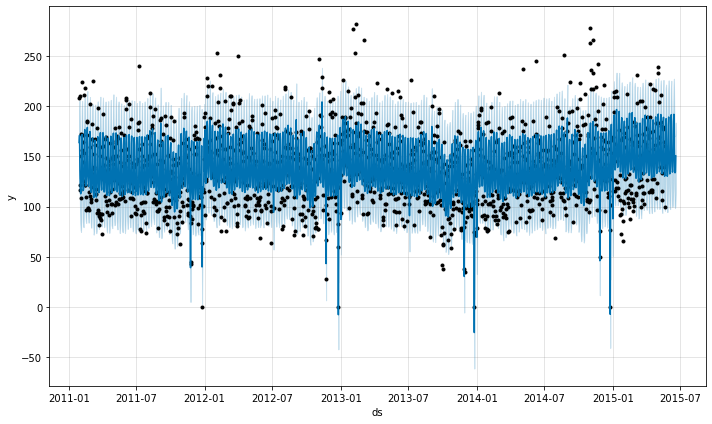

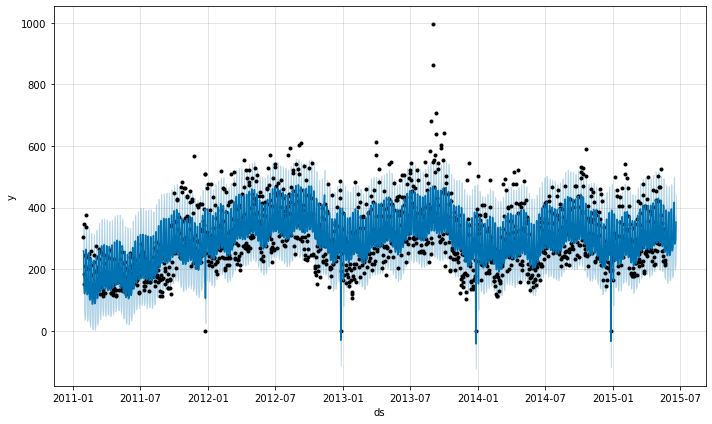

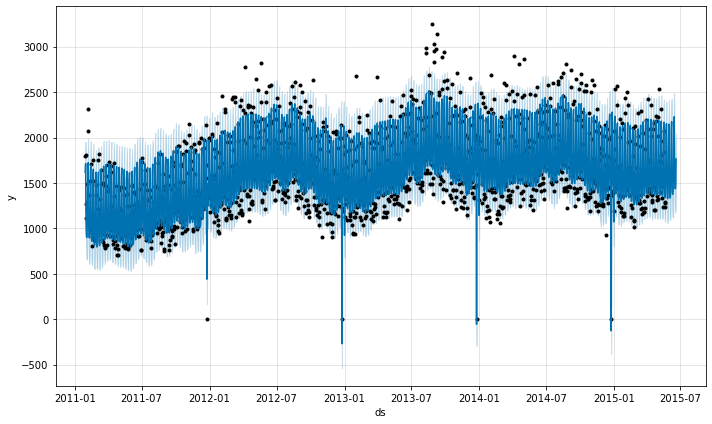

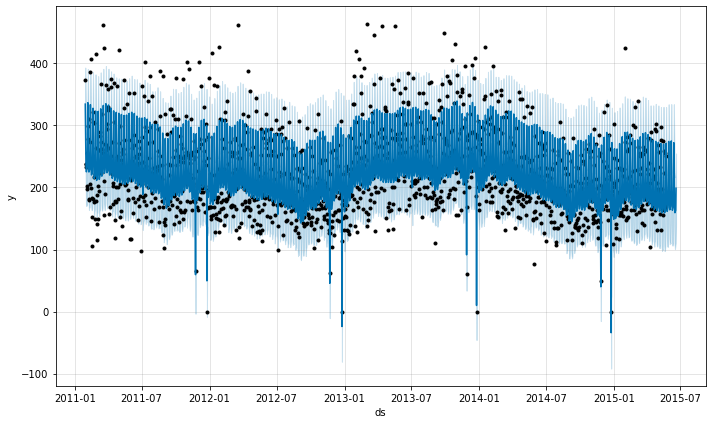

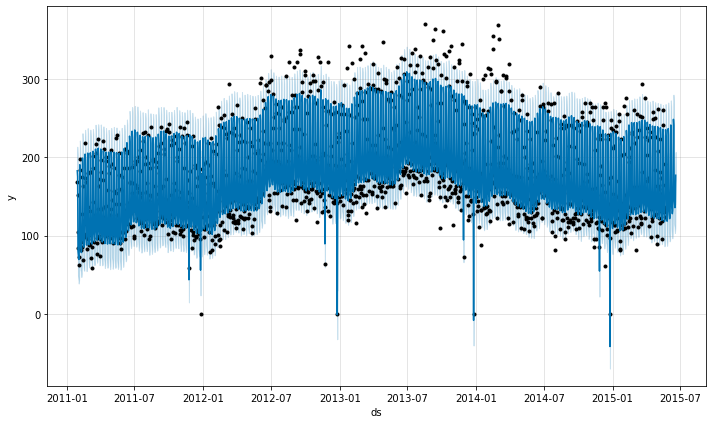

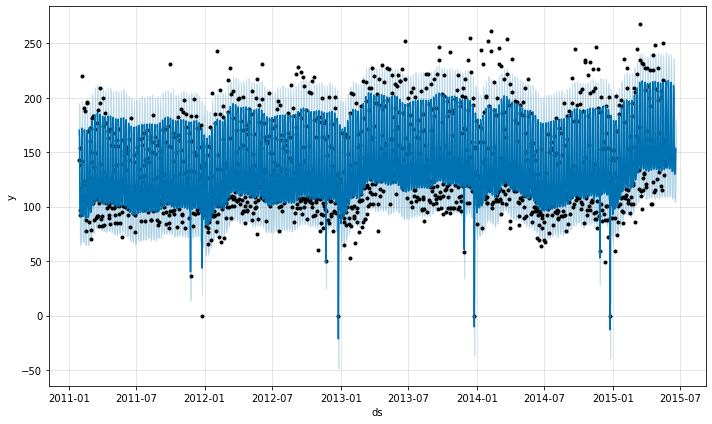

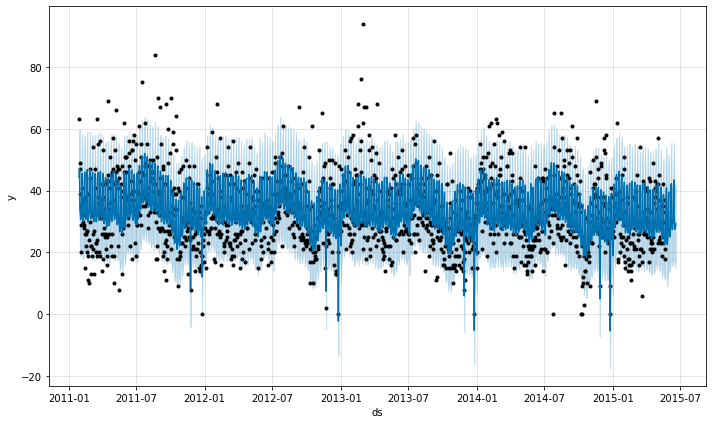

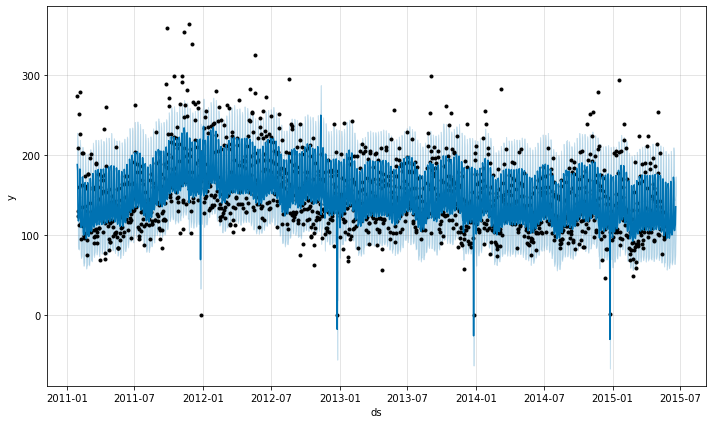

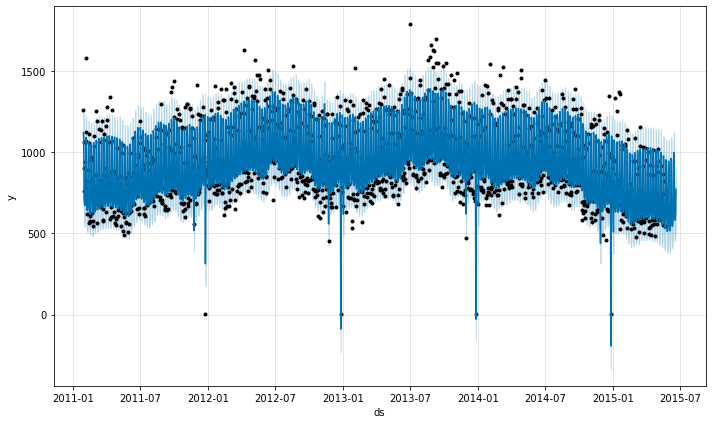

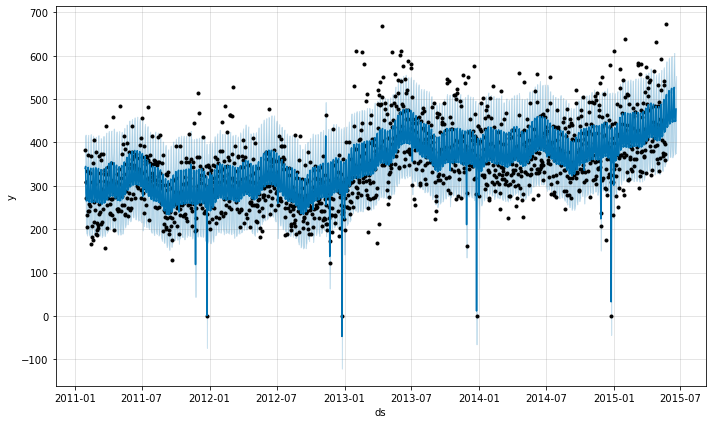

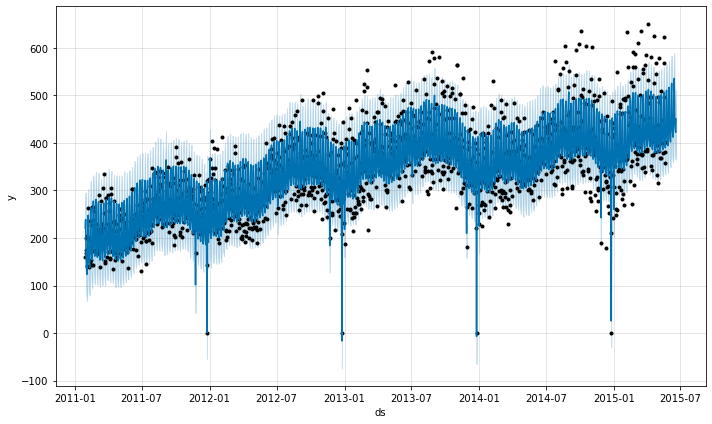

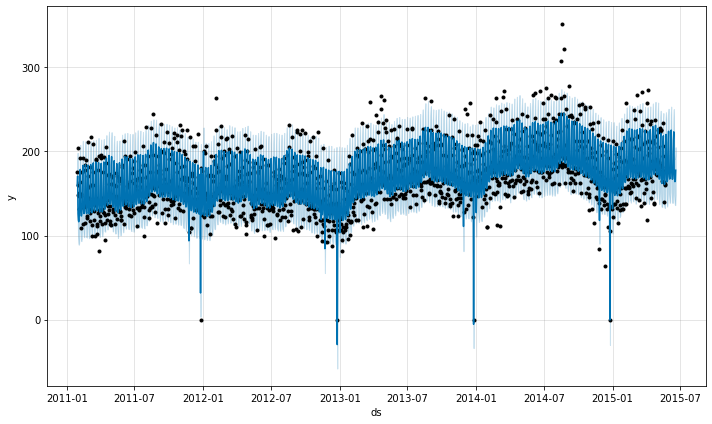

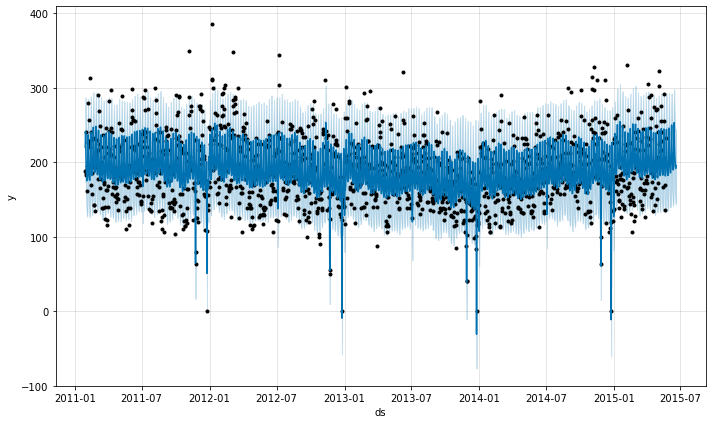

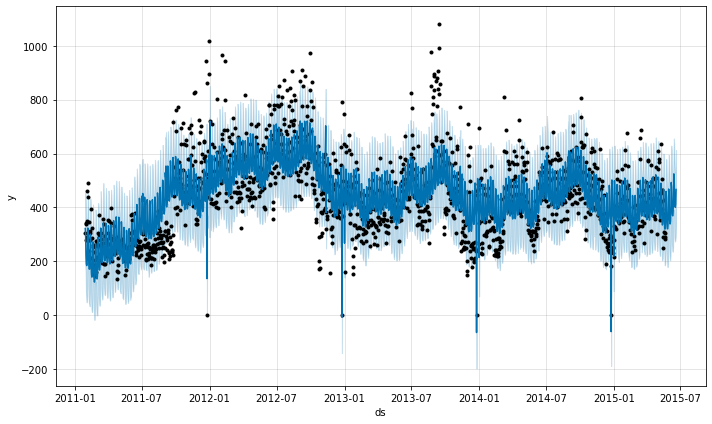

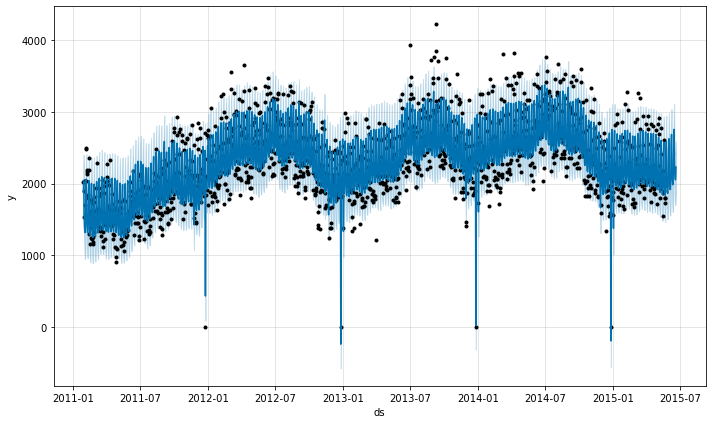

In [13]:
#loop to run forecast for every variable and plot the forecast

summary = []
for i in range(len(train.columns)-1):
    #print(i) 
    predict_data = train.iloc[:, [0,i+1]]
    result = prophetmodel(predict_data)
    summary.append(result)

In [14]:
print(summary[1])

             ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2011-01-29  101.946705  104.597327  172.781508   101.946705   101.946705   
1    2011-01-30  102.044357  122.512049  192.026704   102.044357   102.044357   
2    2011-01-31  102.142009   45.267481  116.525577   102.142009   102.142009   
3    2011-02-01  102.239661   22.043970   93.640251   102.239661   102.239661   
4    2011-02-02  102.337313   14.147500   86.074707   102.337313   102.337313   
...         ...         ...         ...         ...          ...          ...   
1598 2015-06-15  247.994577  212.464756  283.706630   247.943857   248.051177   
1599 2015-06-16  248.075873  192.862573  262.689014   248.017714   248.140884   
1600 2015-06-17  248.157169  183.645198  253.660886   248.092405   248.231127   
1601 2015-06-18  248.238466  187.603116  262.401565   248.164631   248.319712   
1602 2015-06-19  248.319762  217.455037  287.563188   248.237161   248.409064   

      Christmas Day  Christ

In [15]:
#loop to add predict values : yhat for every variable 

y_hat = []
for i in range(len(summary)):
   y_hat.append(summary[i].yhat)

#convert list to dataframe and add date and columns
y_hat_total = pd.DataFrame(y_hat)
y_hat_total = y_hat_total.transpose()
date =summary[0].ds
y_hat_total.insert(0, column='date', value=date)
y_hat_total.columns = data.columns

#export to csv file to read in r
y_hat_total.to_csv('forecast_summary.csv', index=False)

print(y_hat_total)

           date  Hobbies_CA_1  Household_1_CA_1  Household_2_CA_1  \
0    2011-01-29    390.101687        140.011160         98.536622   
1    2011-01-30    346.845948        157.543181         93.336378   
2    2011-01-31    291.289783         80.489548         55.632720   
3    2011-02-01    277.641777         59.014241         51.013898   
4    2011-02-02    274.501645         51.024559         50.568496   
...         ...           ...               ...               ...   
1598 2015-06-15    361.574075        250.158787        129.683172   
1599 2015-06-16    346.422964        228.250805        124.579295   
1600 2015-06-17    341.710441        219.776425        123.691452   
1601 2015-06-18    346.019212        222.596462        128.260342   
1602 2015-06-19    388.492848        252.786290        145.145924   

      Foods_1_CA_1  Foods_2_CA_1  Foods_3_CA_1  Hobbies_CA_2  \
0       163.742774    259.124783   1617.869068    334.376864   
1       170.910018    259.146424   1711.556

In [16]:
y_hat_total.iloc[:,1]

0       390.101687
1       346.845948
2       291.289783
3       277.641777
4       274.501645
           ...    
1598    361.574075
1599    346.422964
1600    341.710441
1601    346.019212
1602    388.492848
Name: Hobbies_CA_1, Length: 1603, dtype: float64

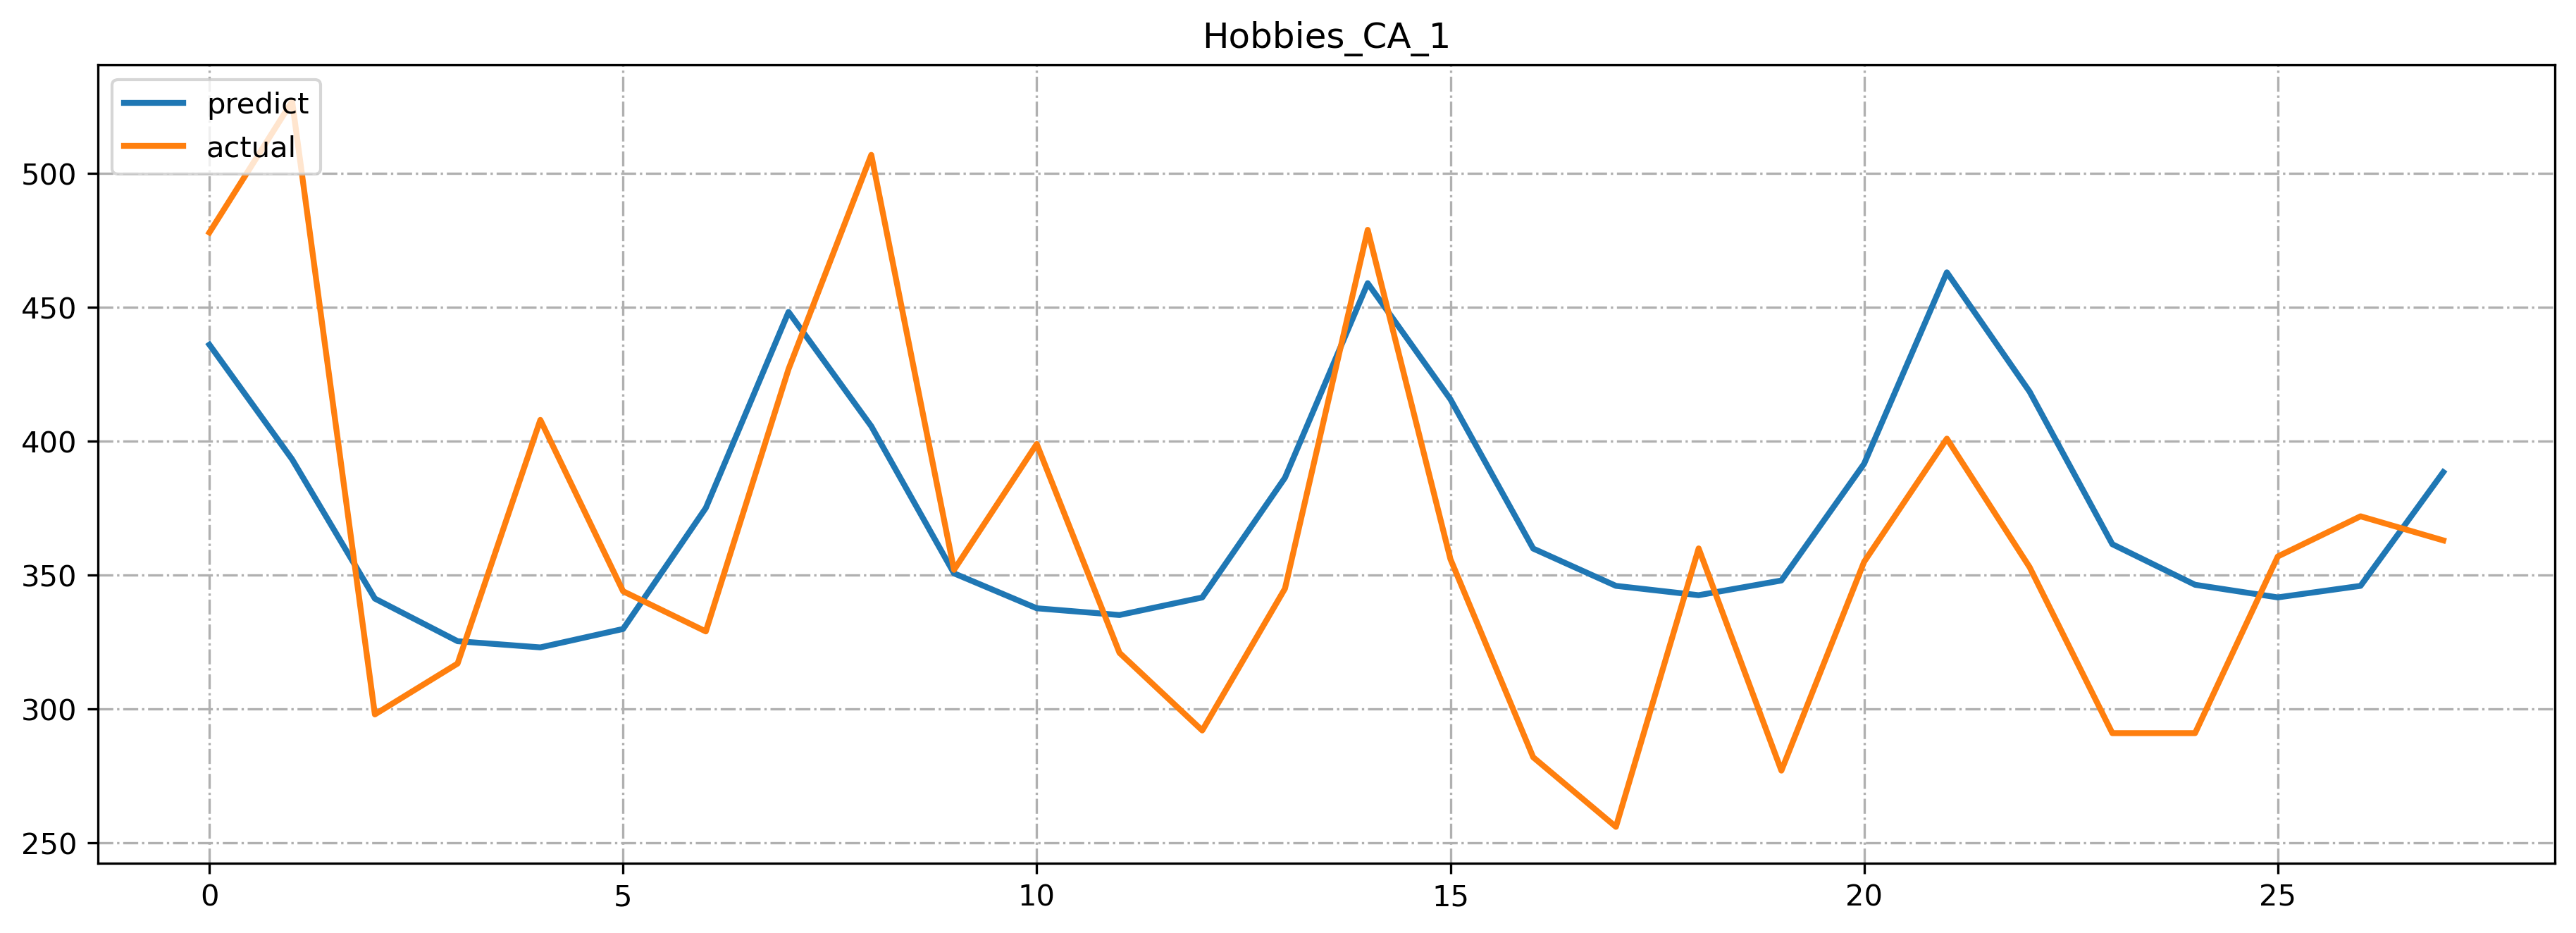

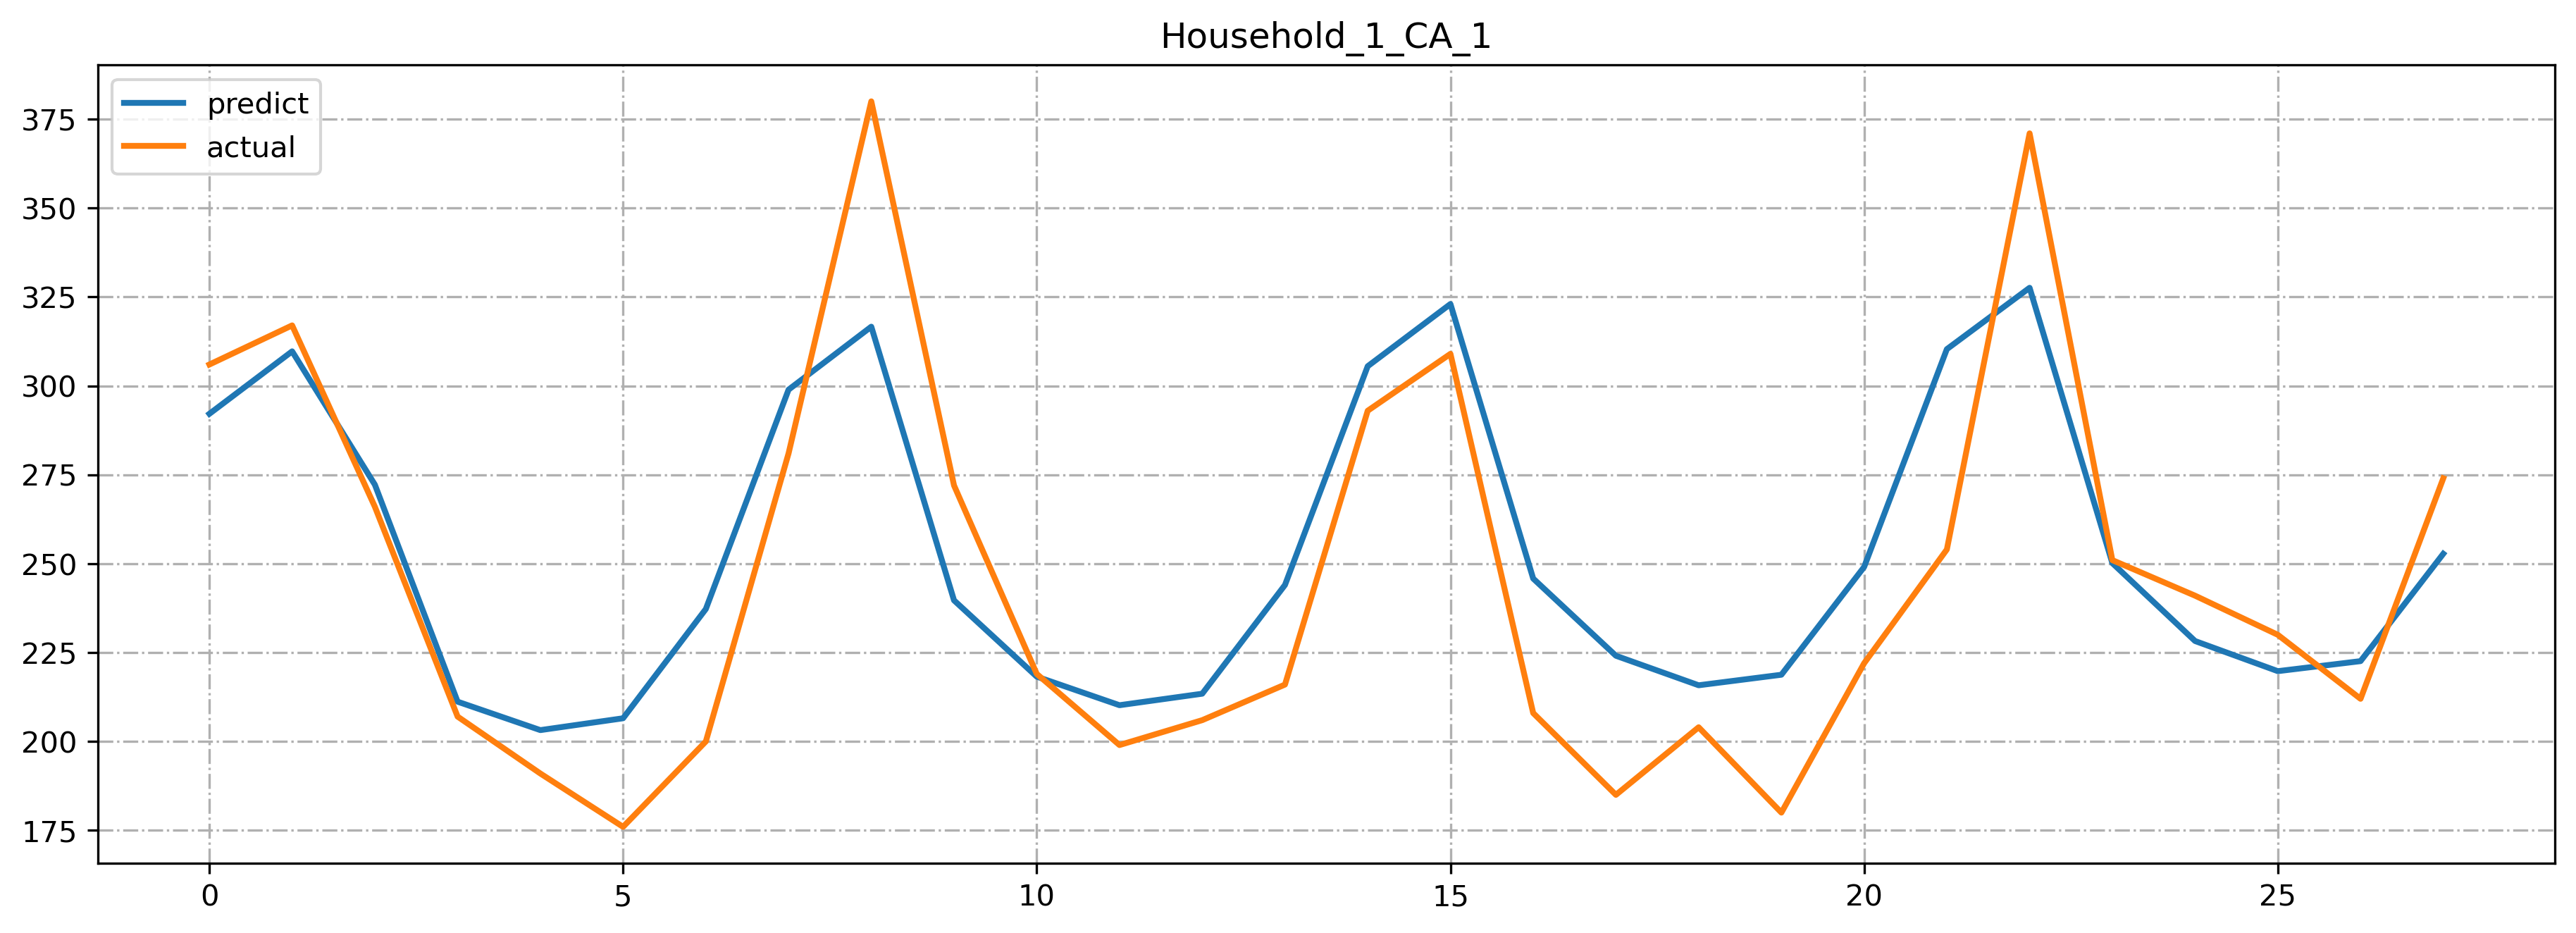

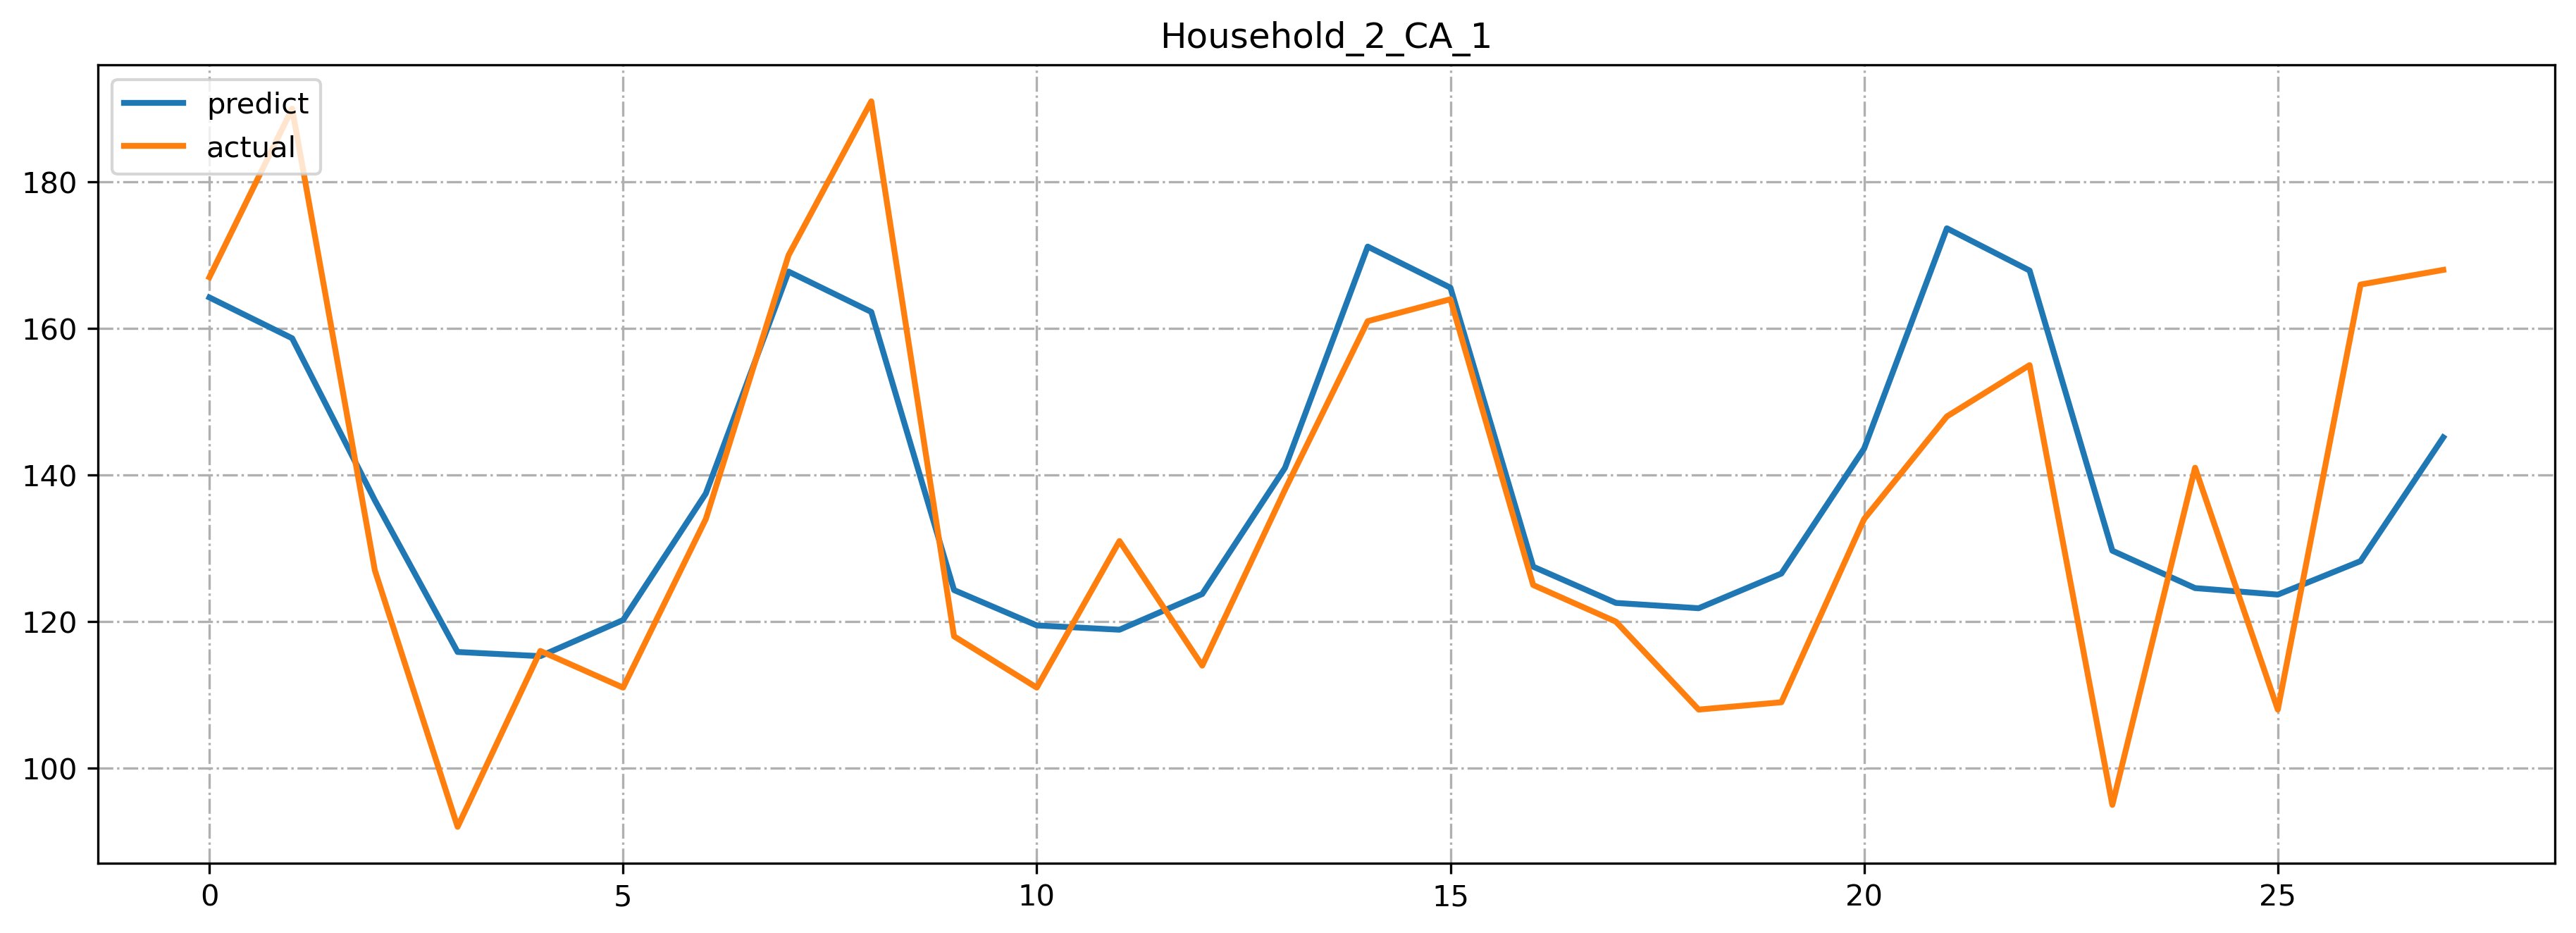

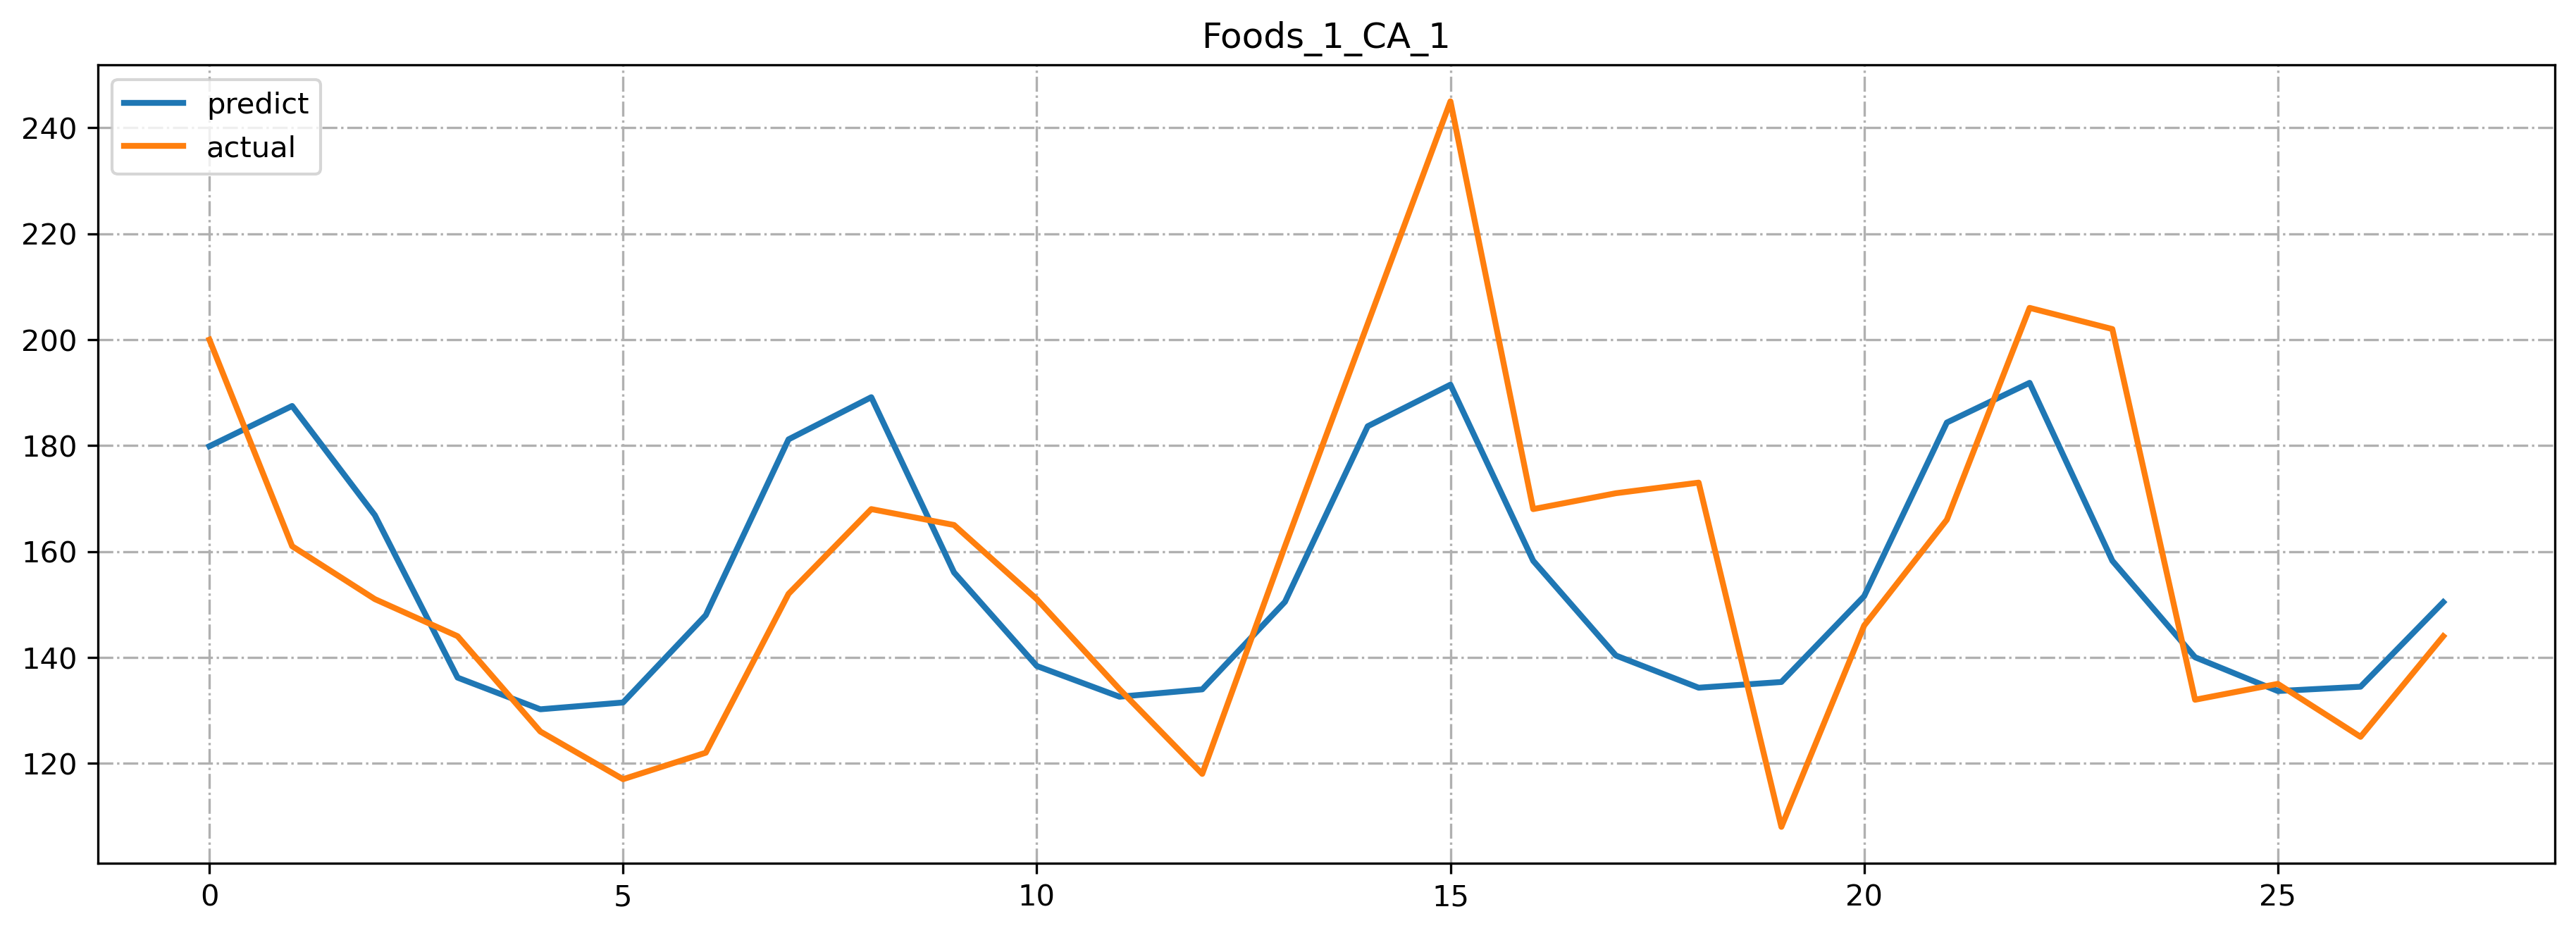

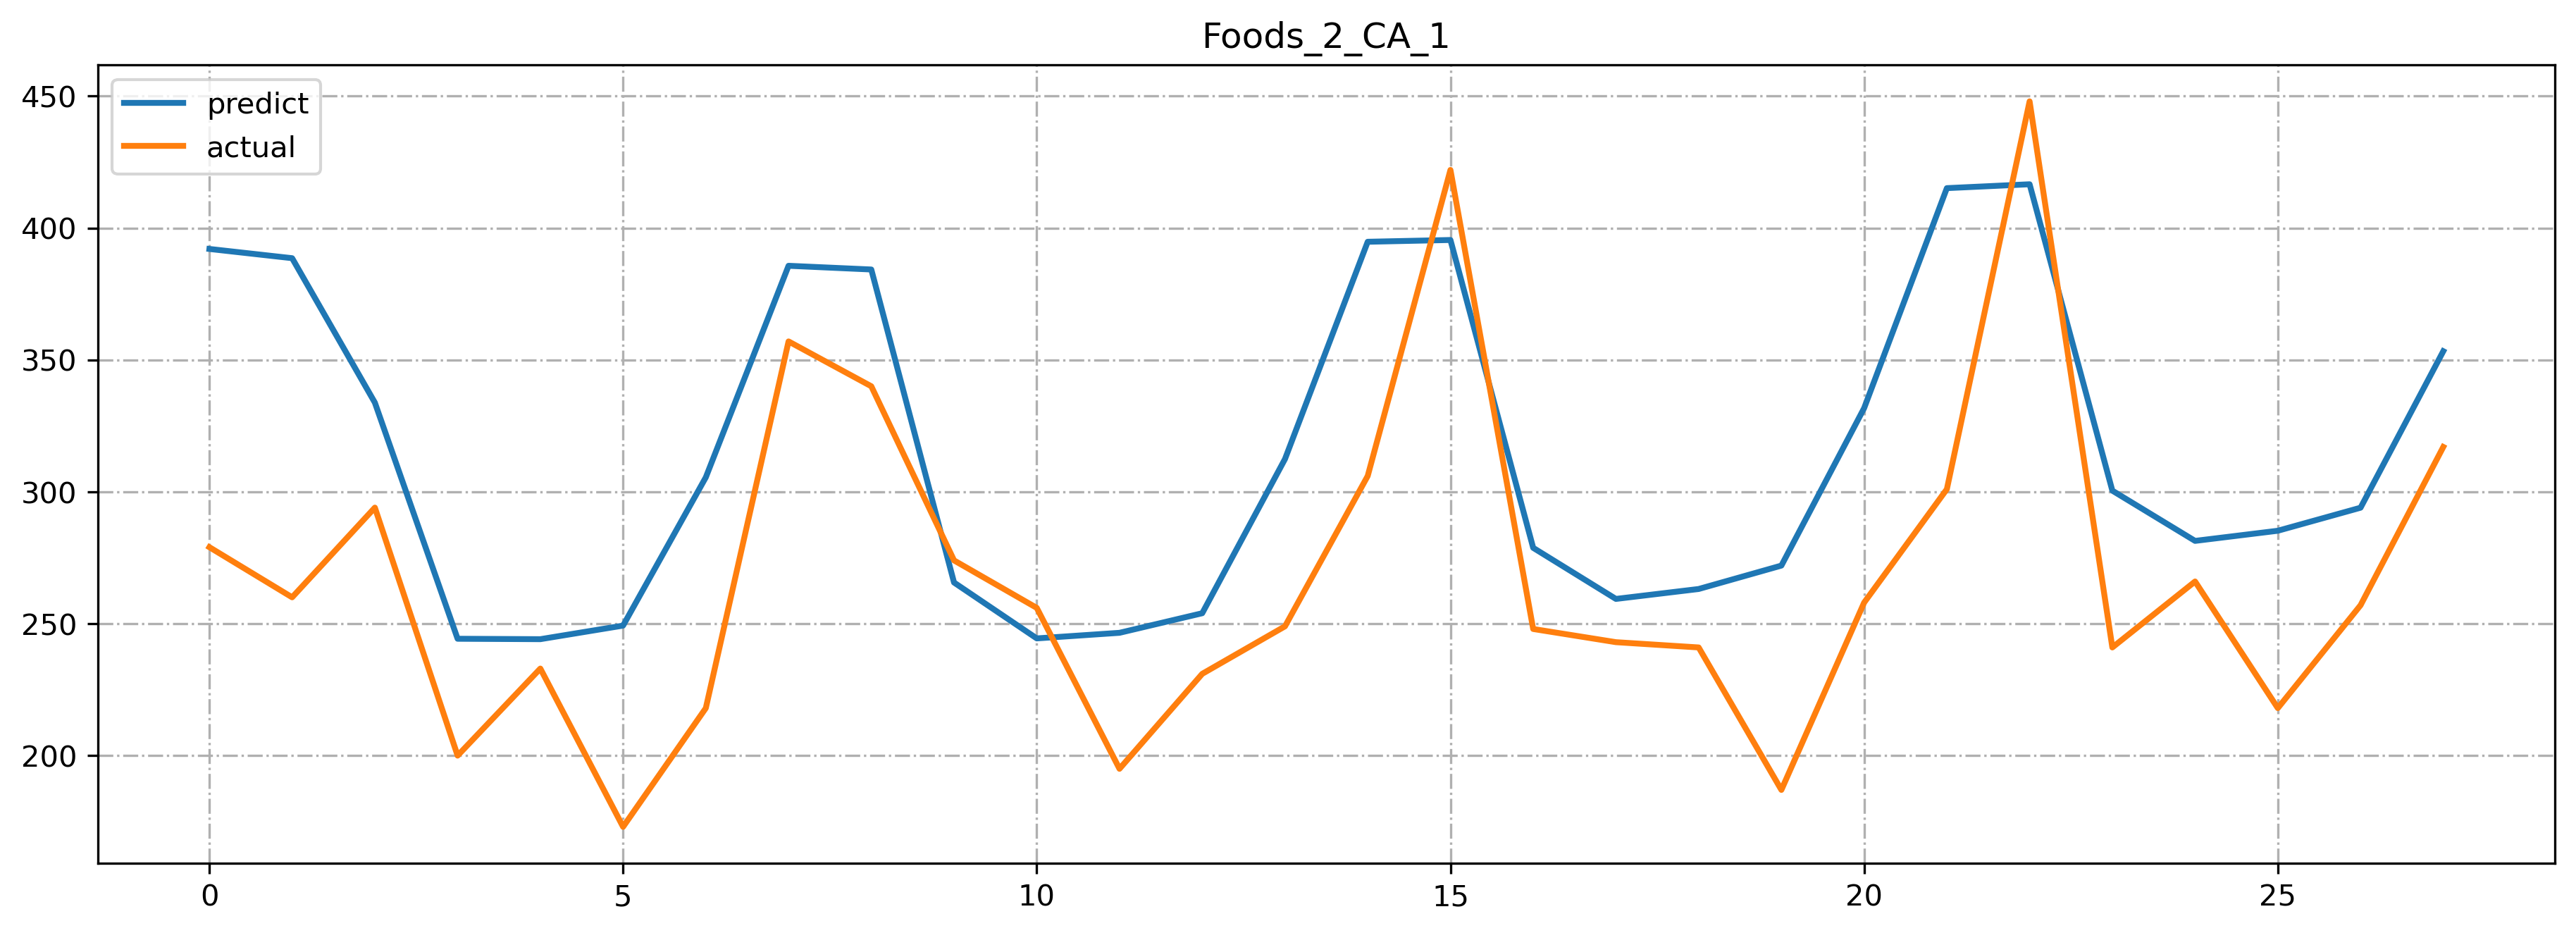

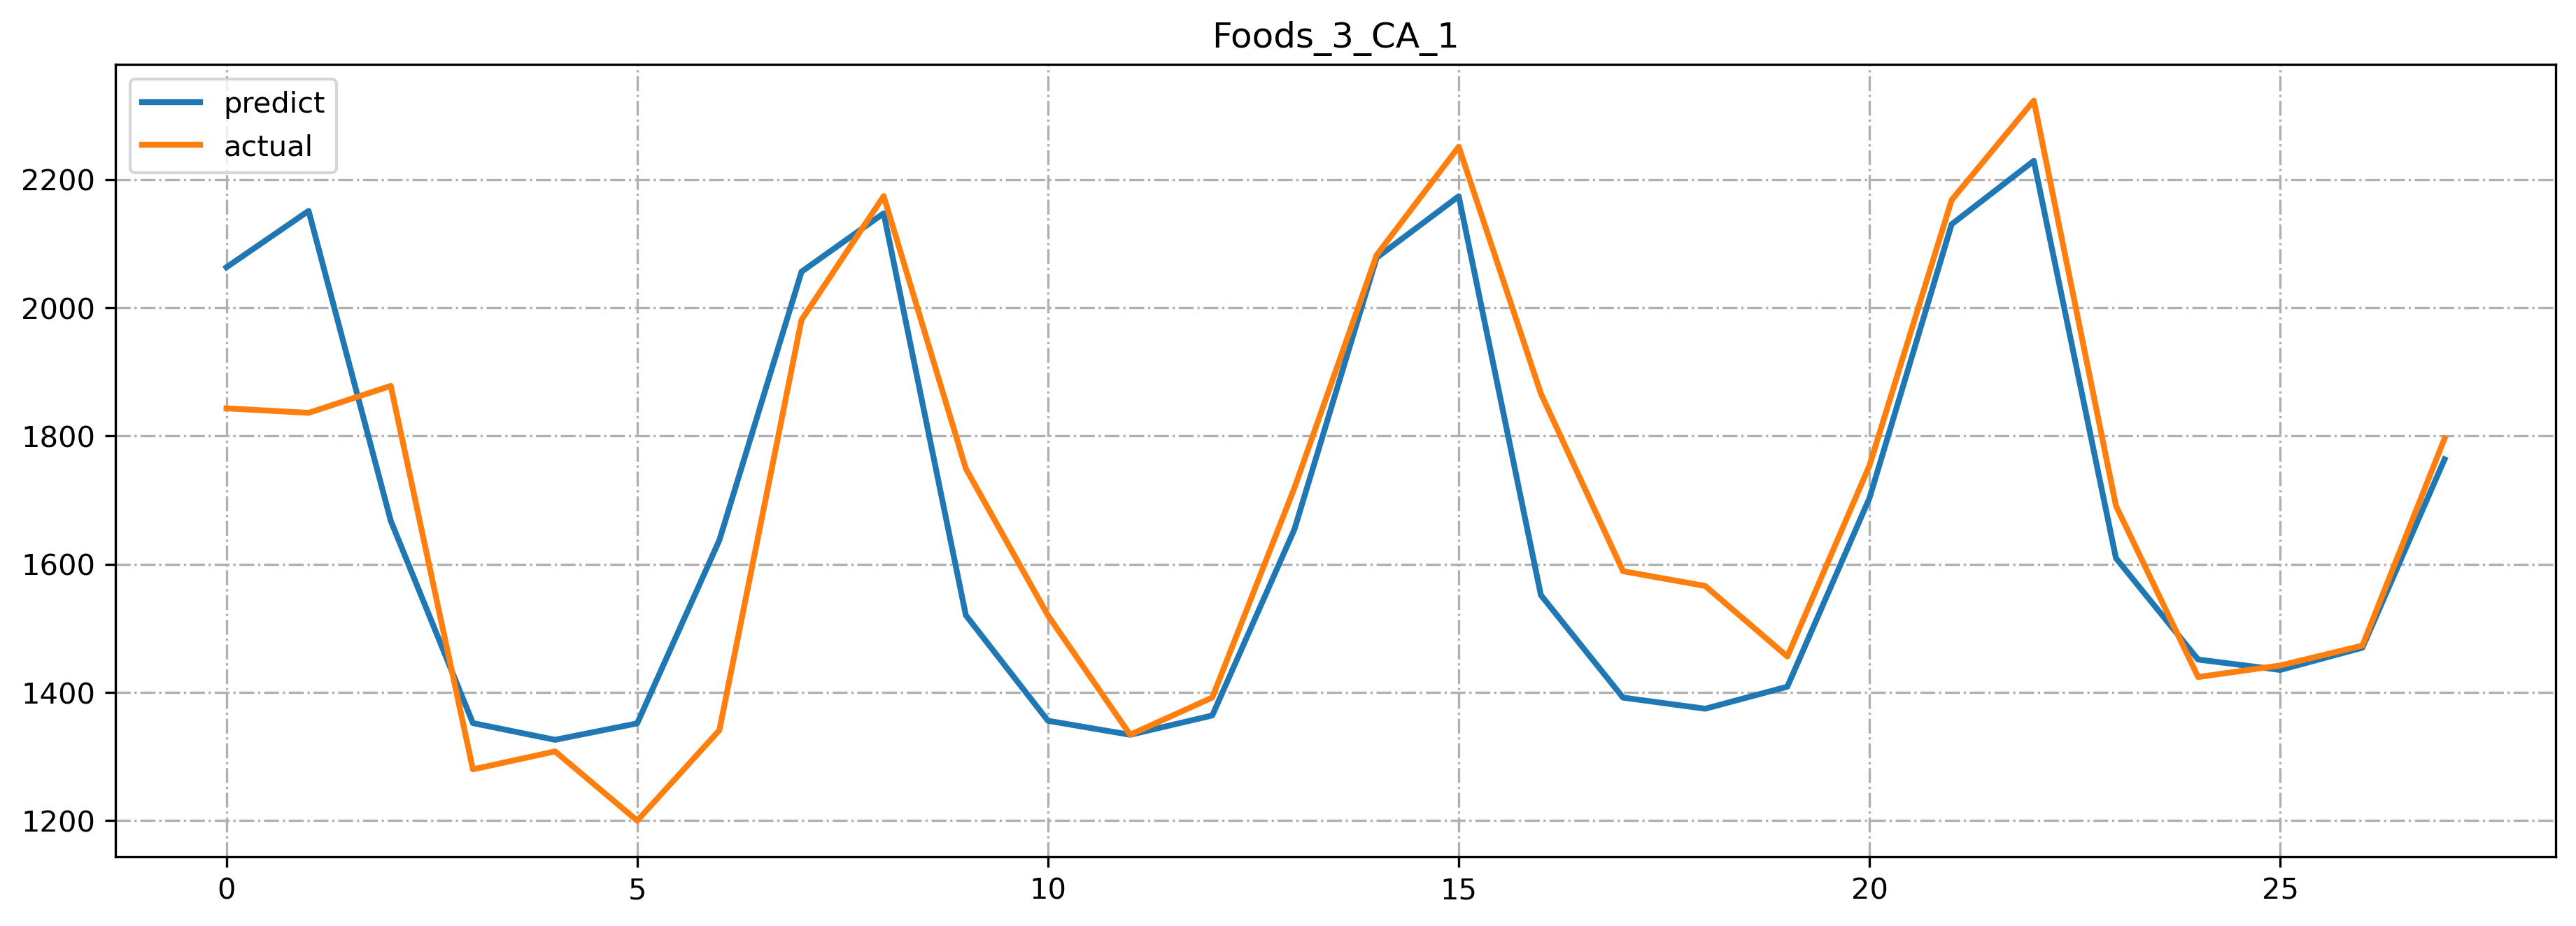

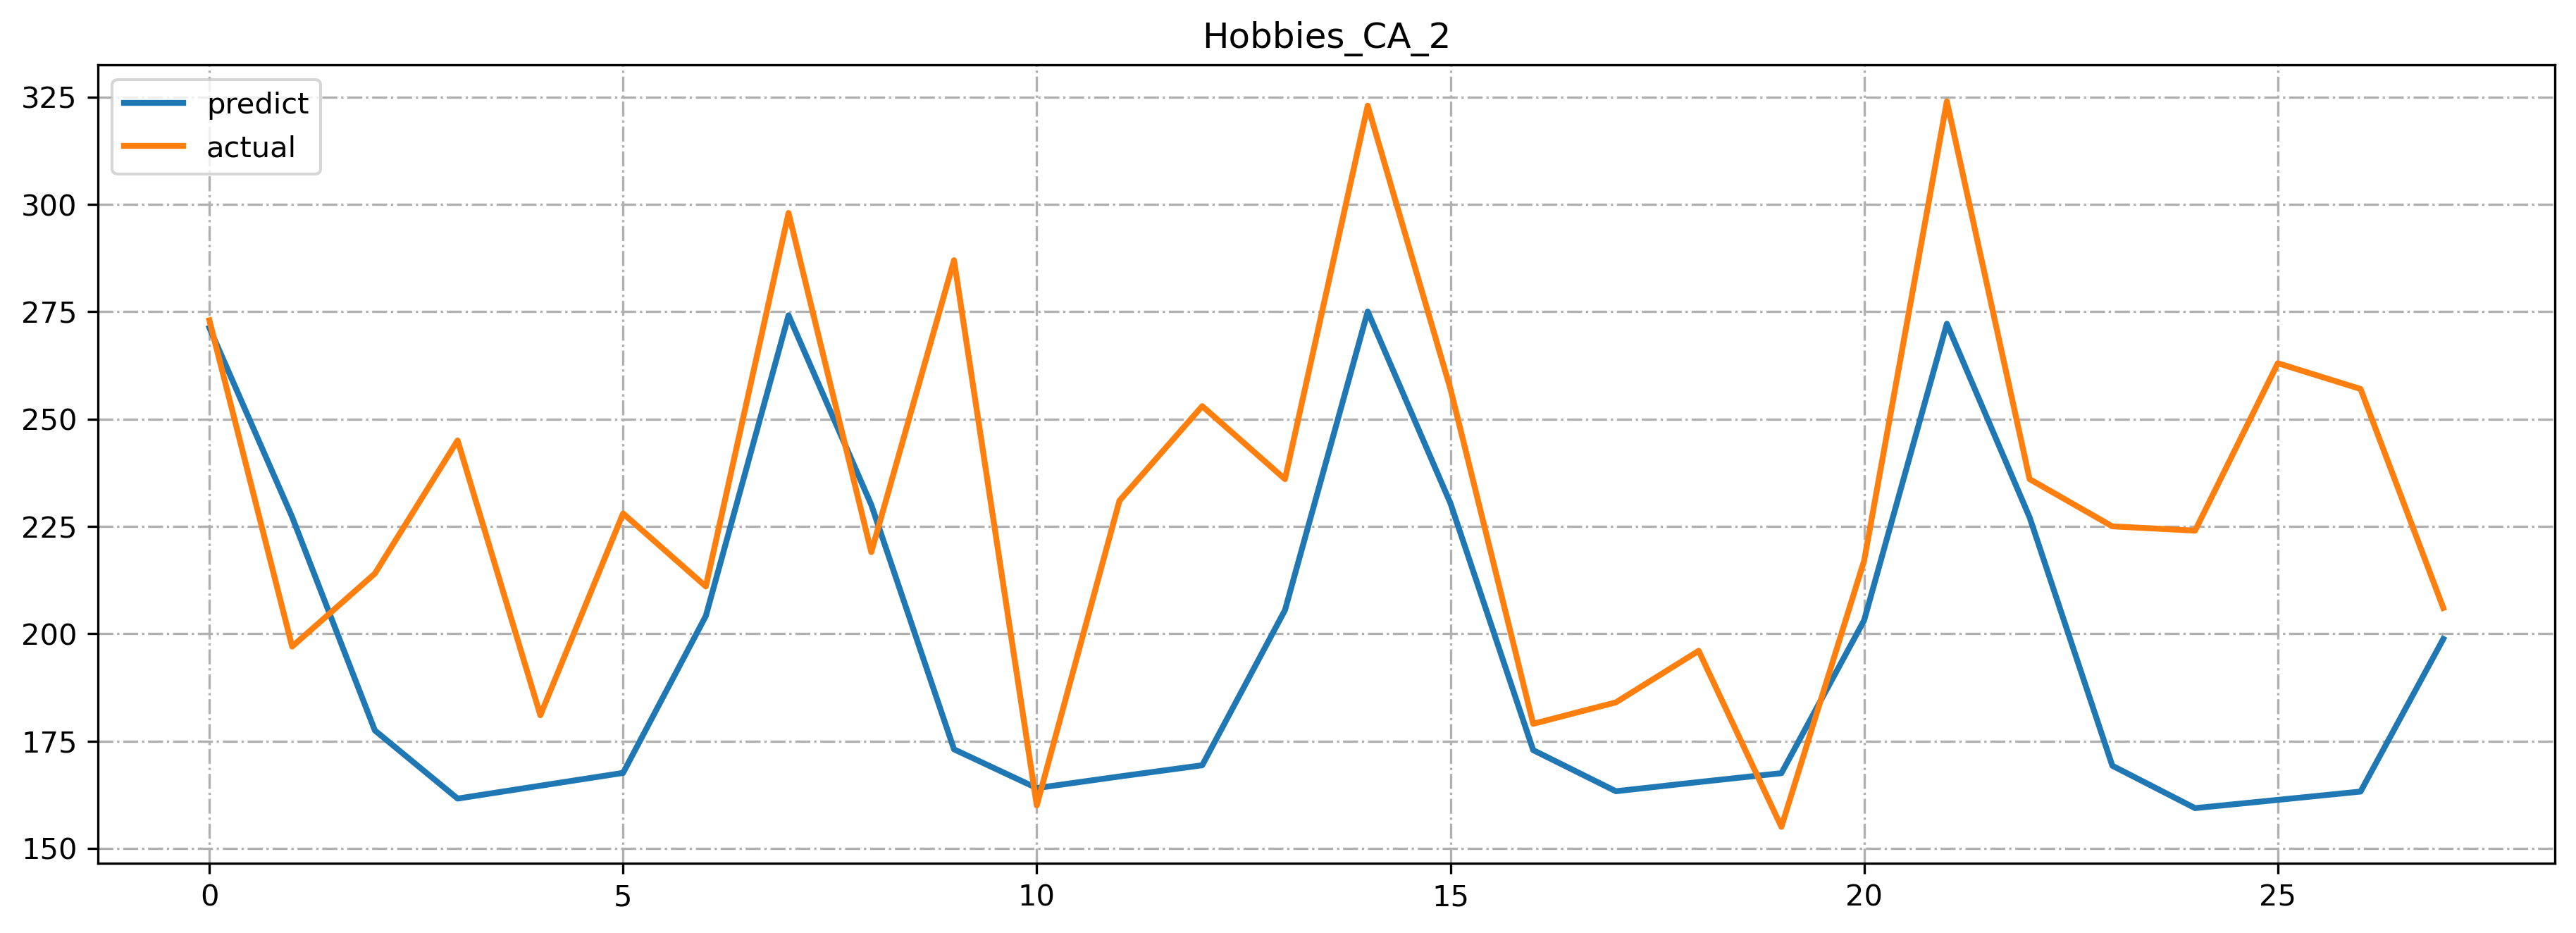

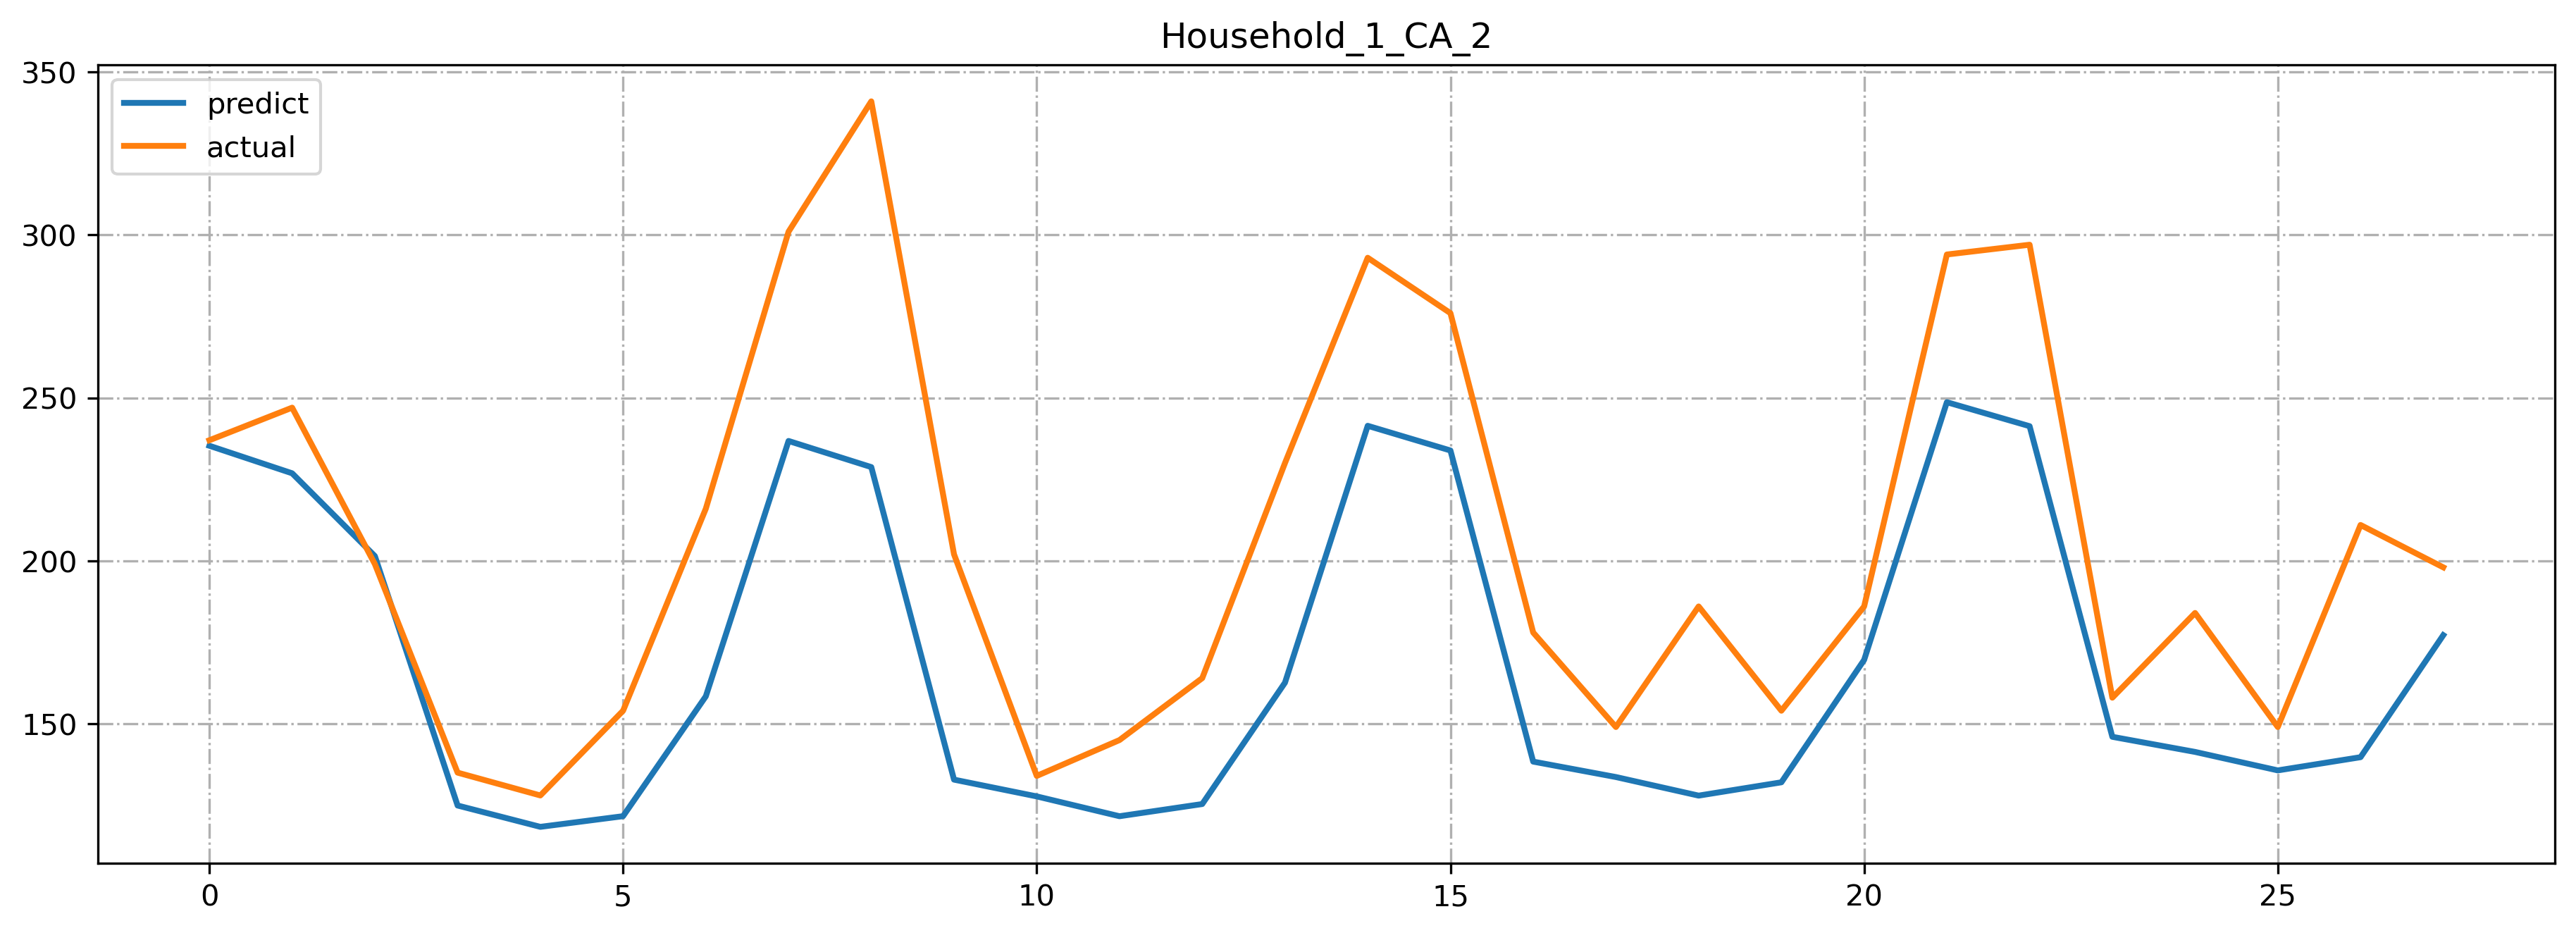

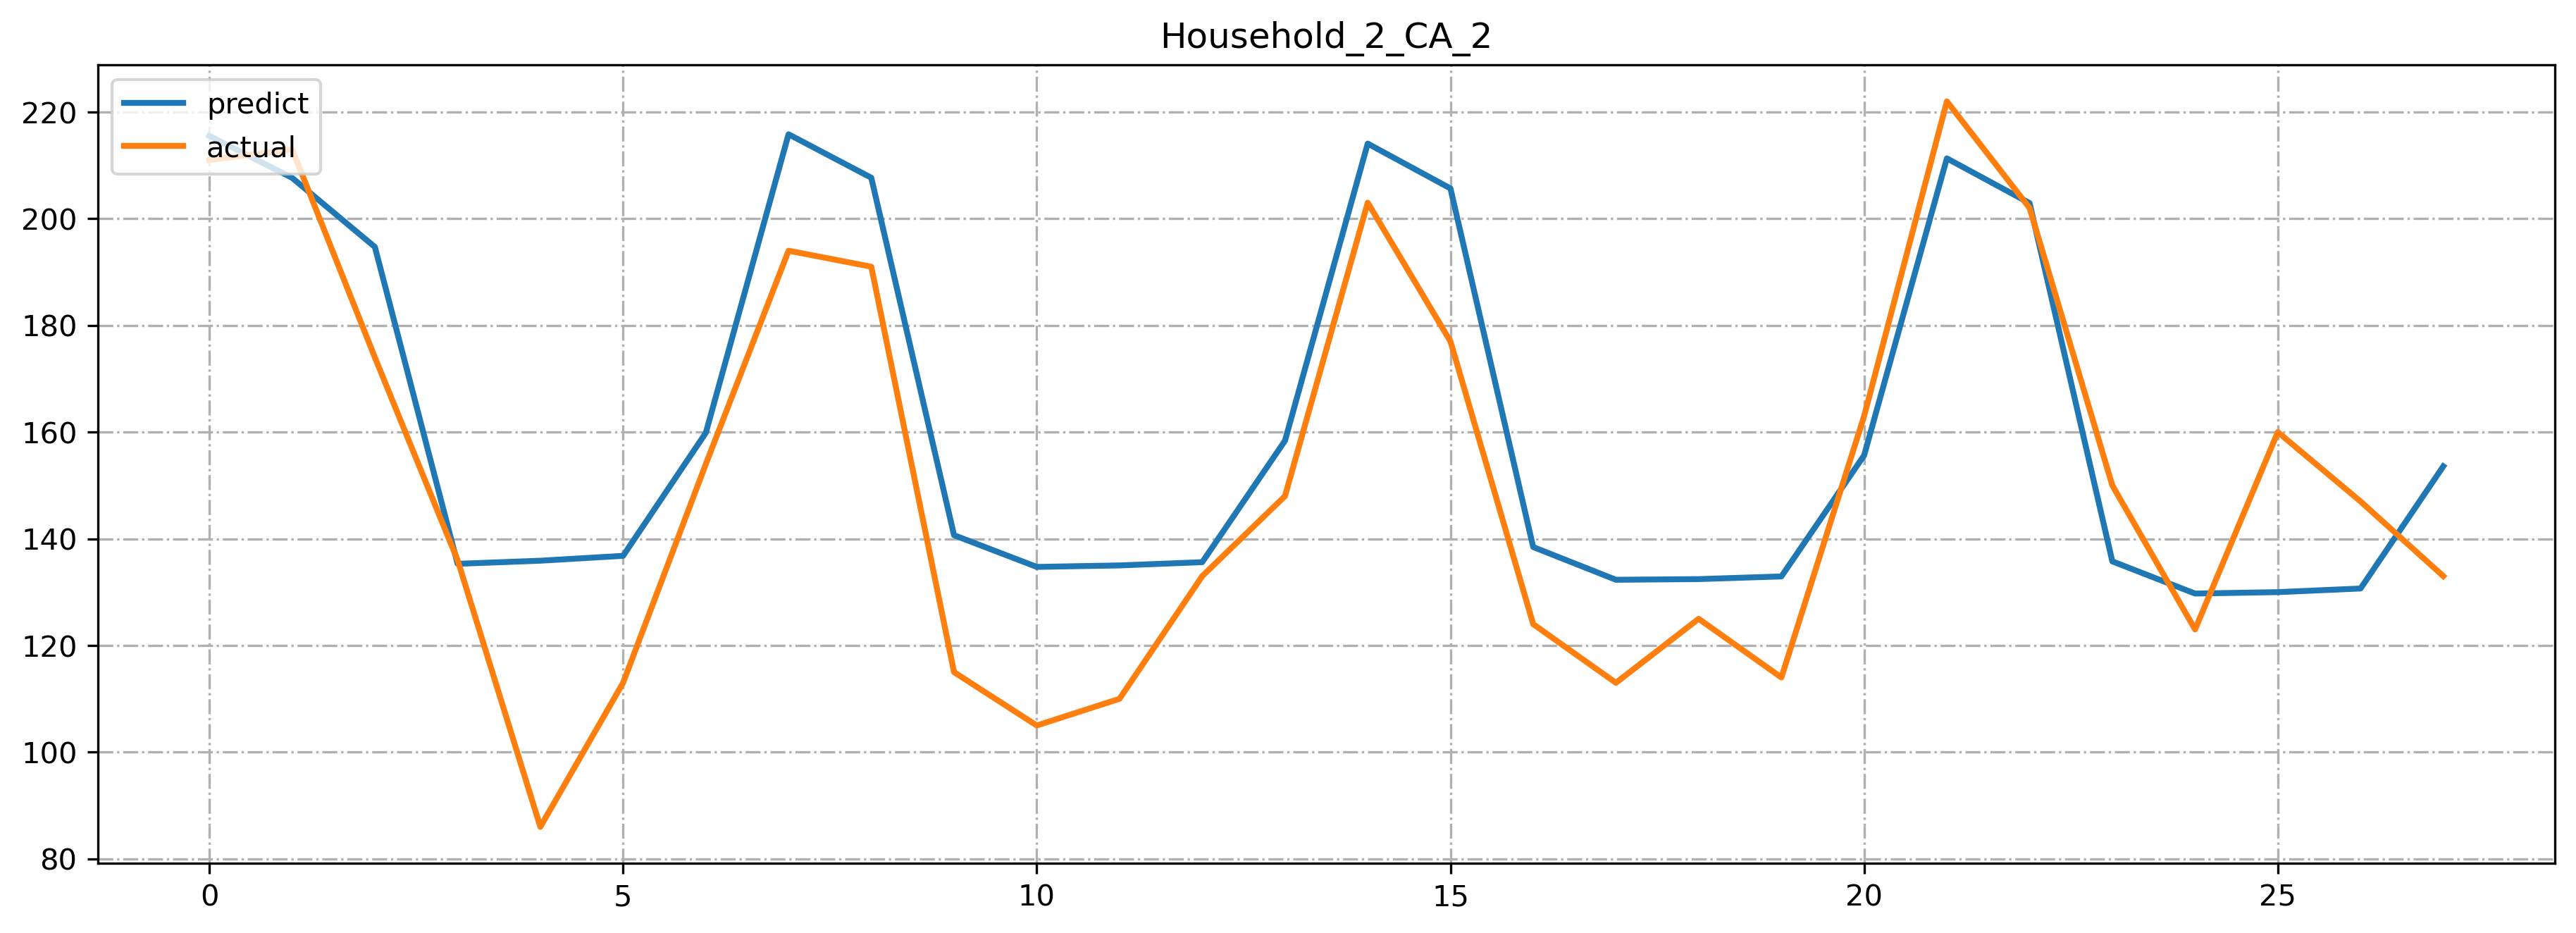

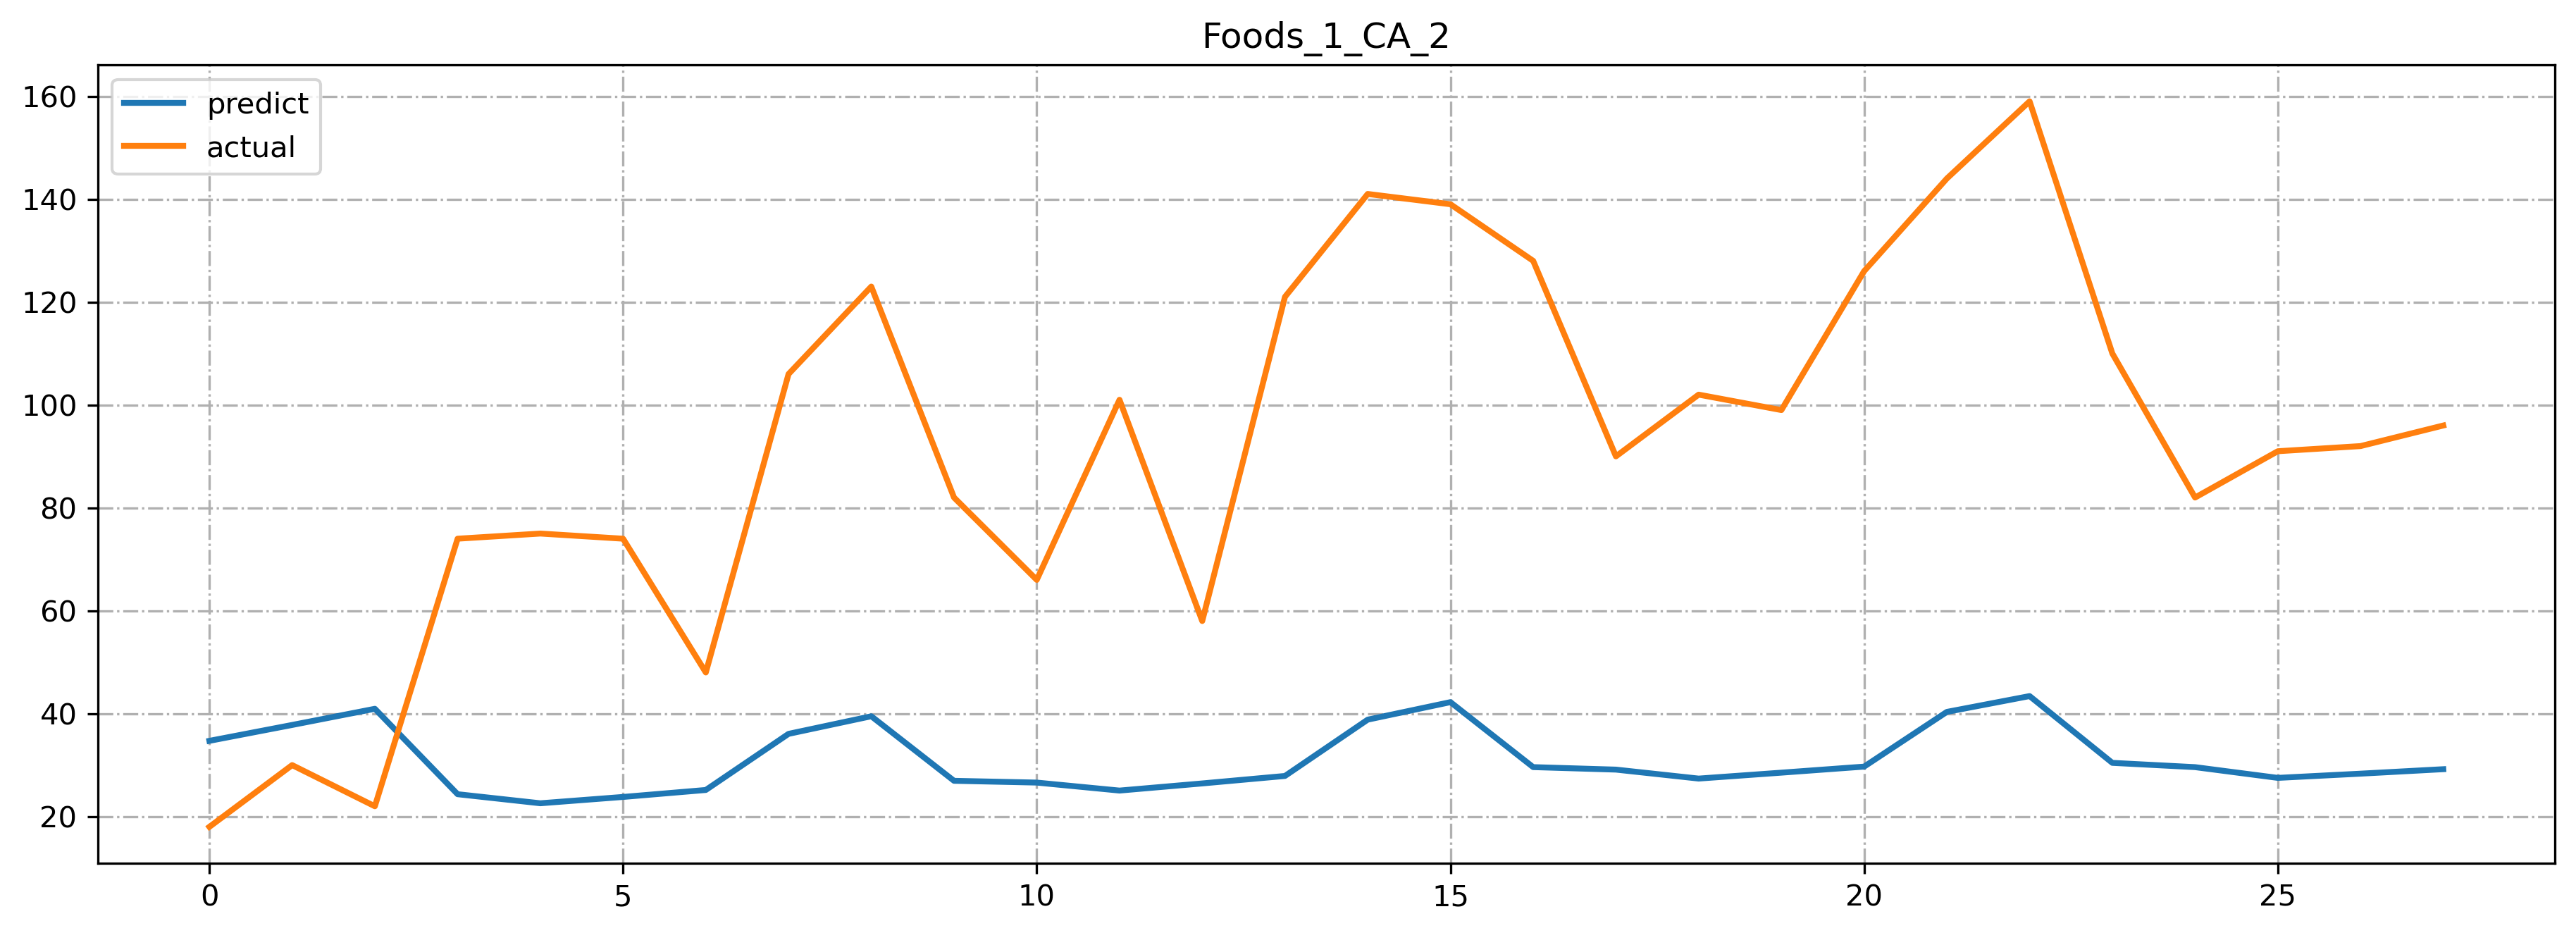

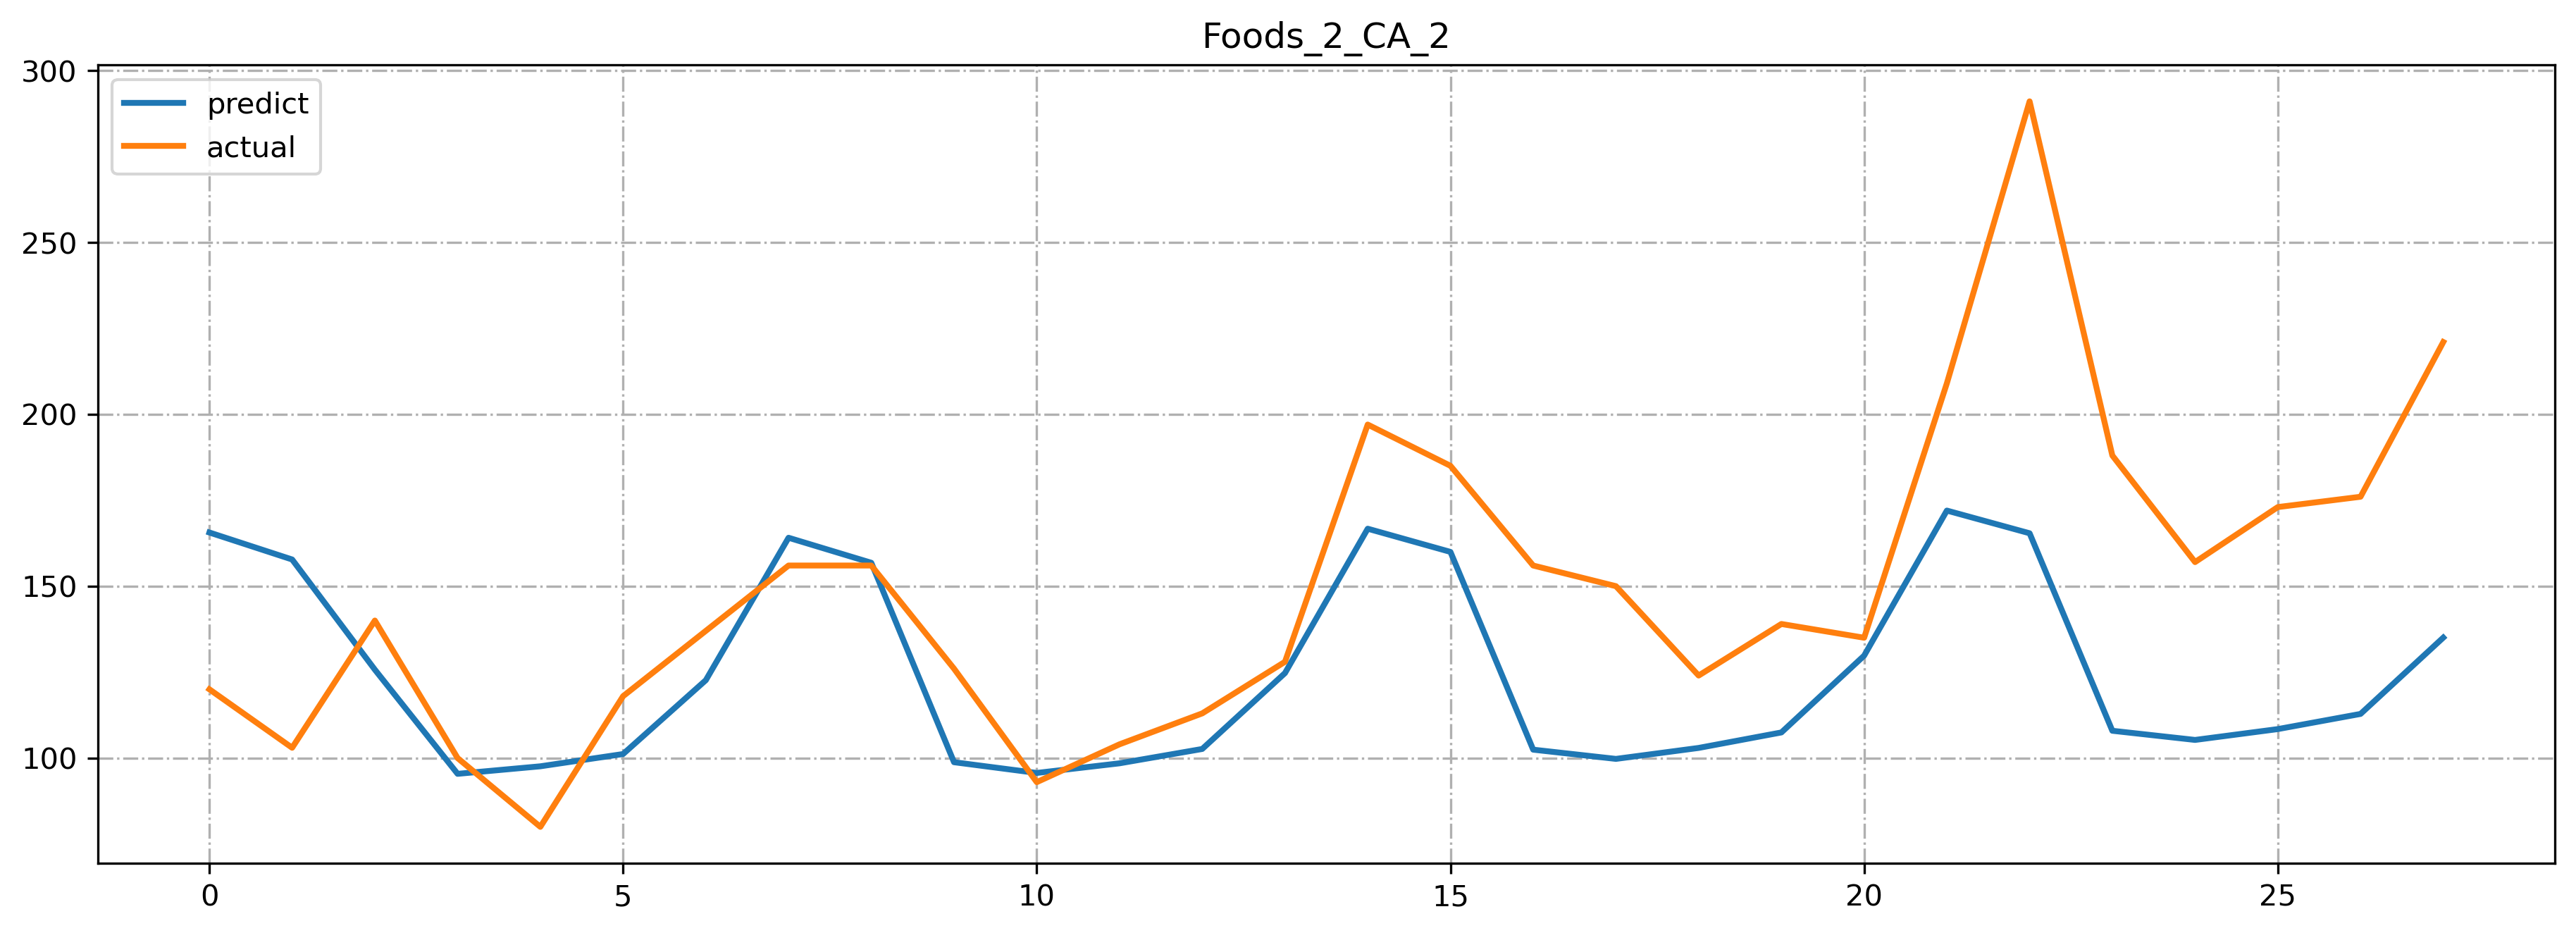

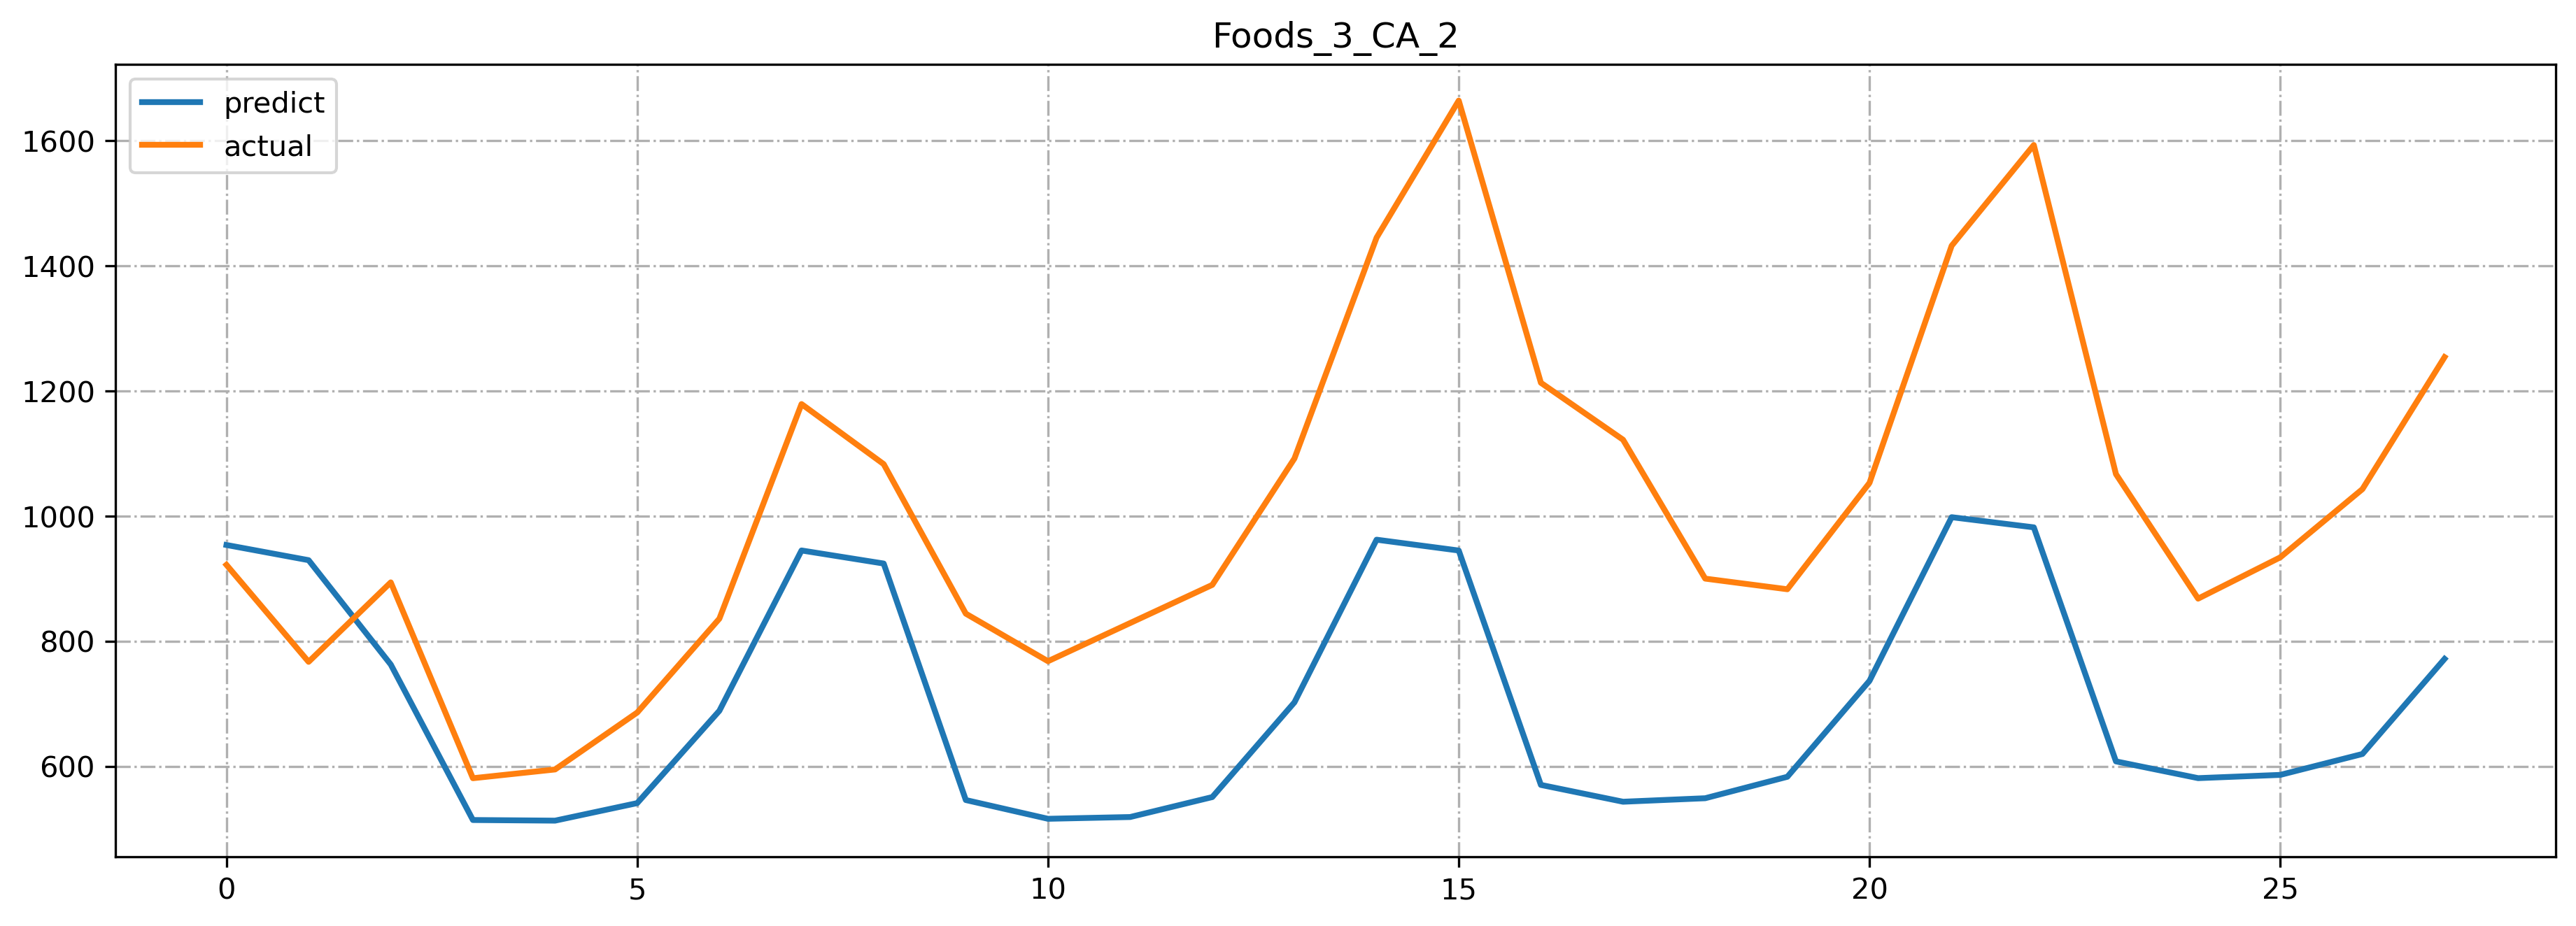

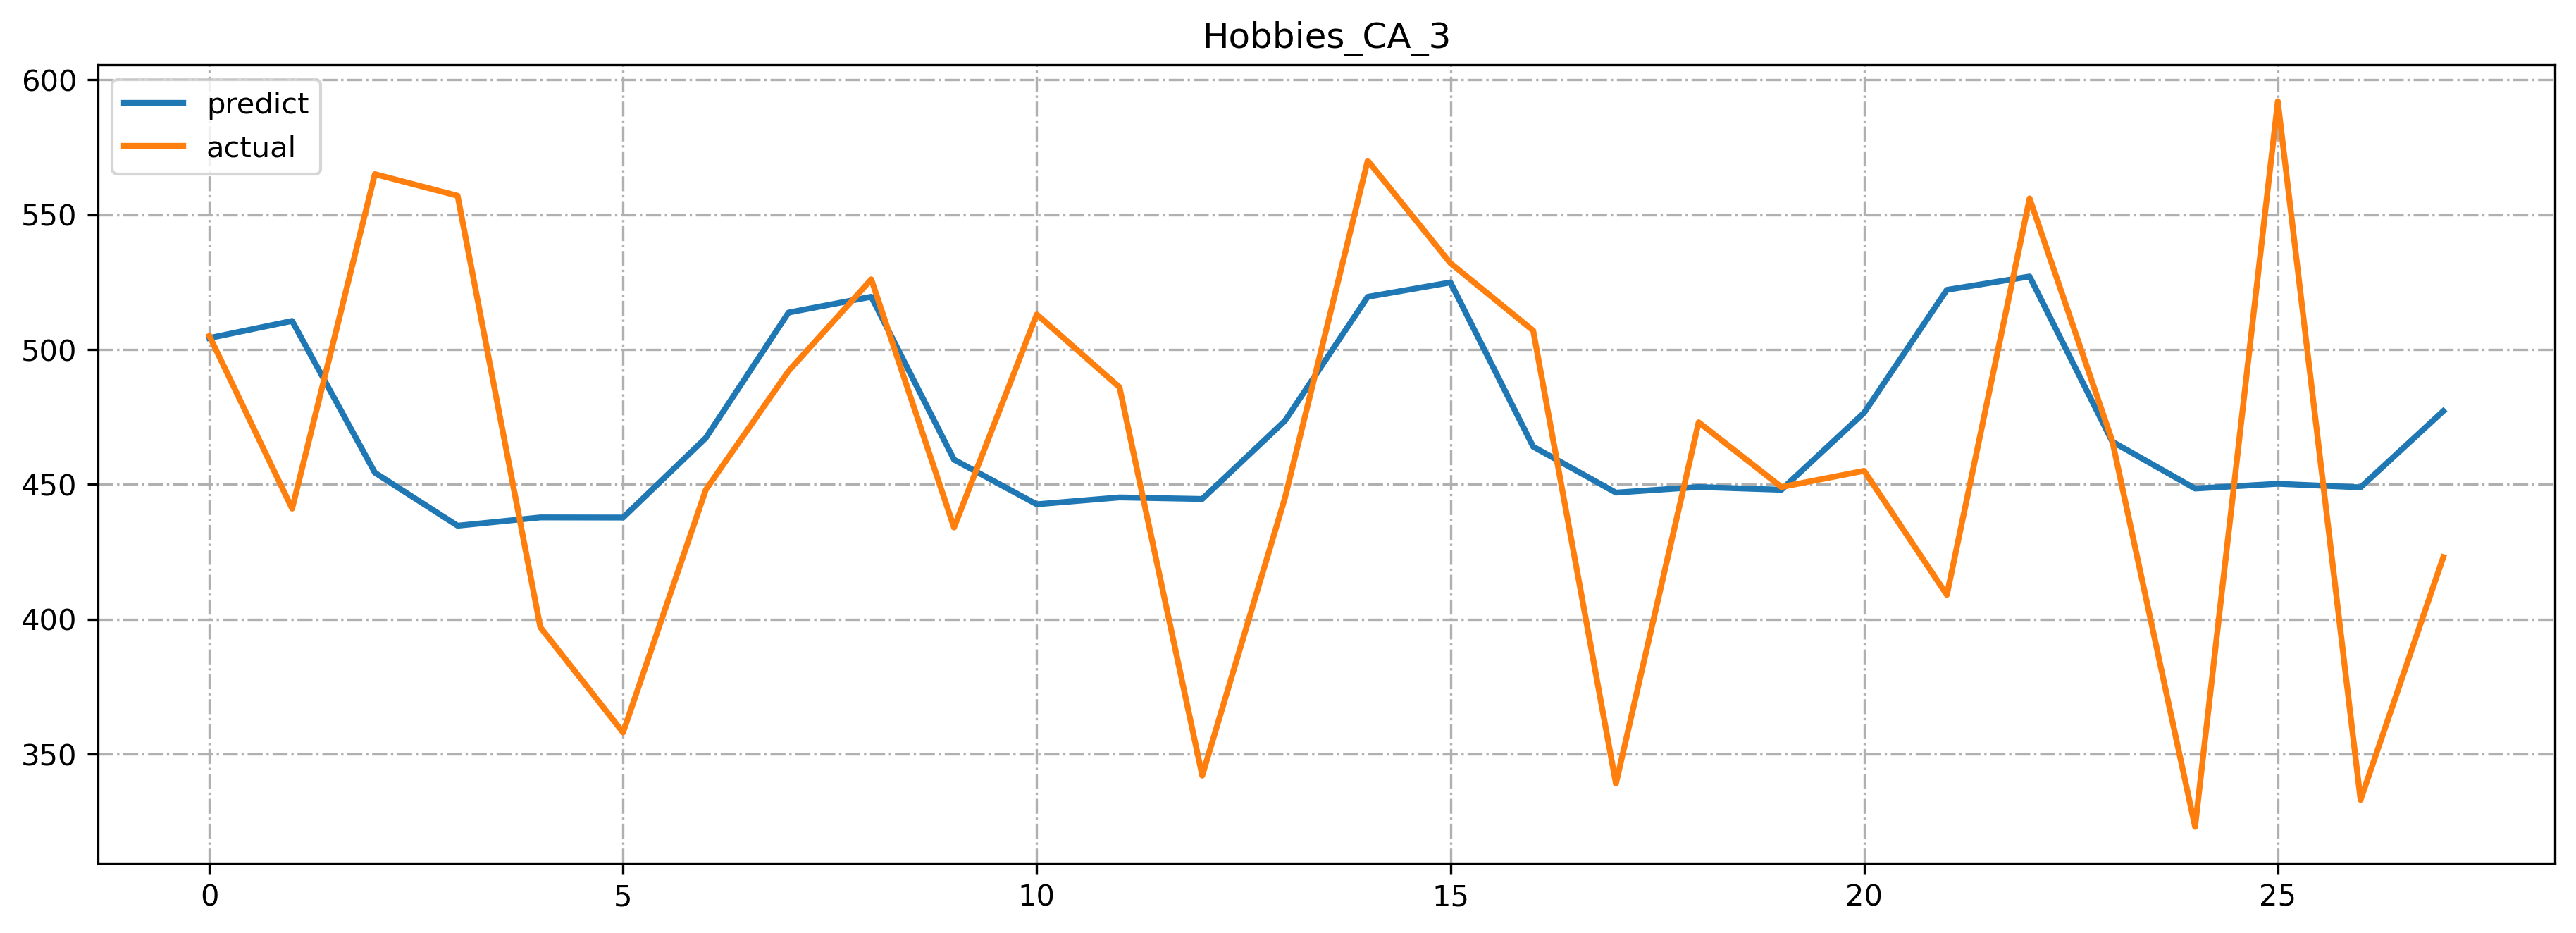

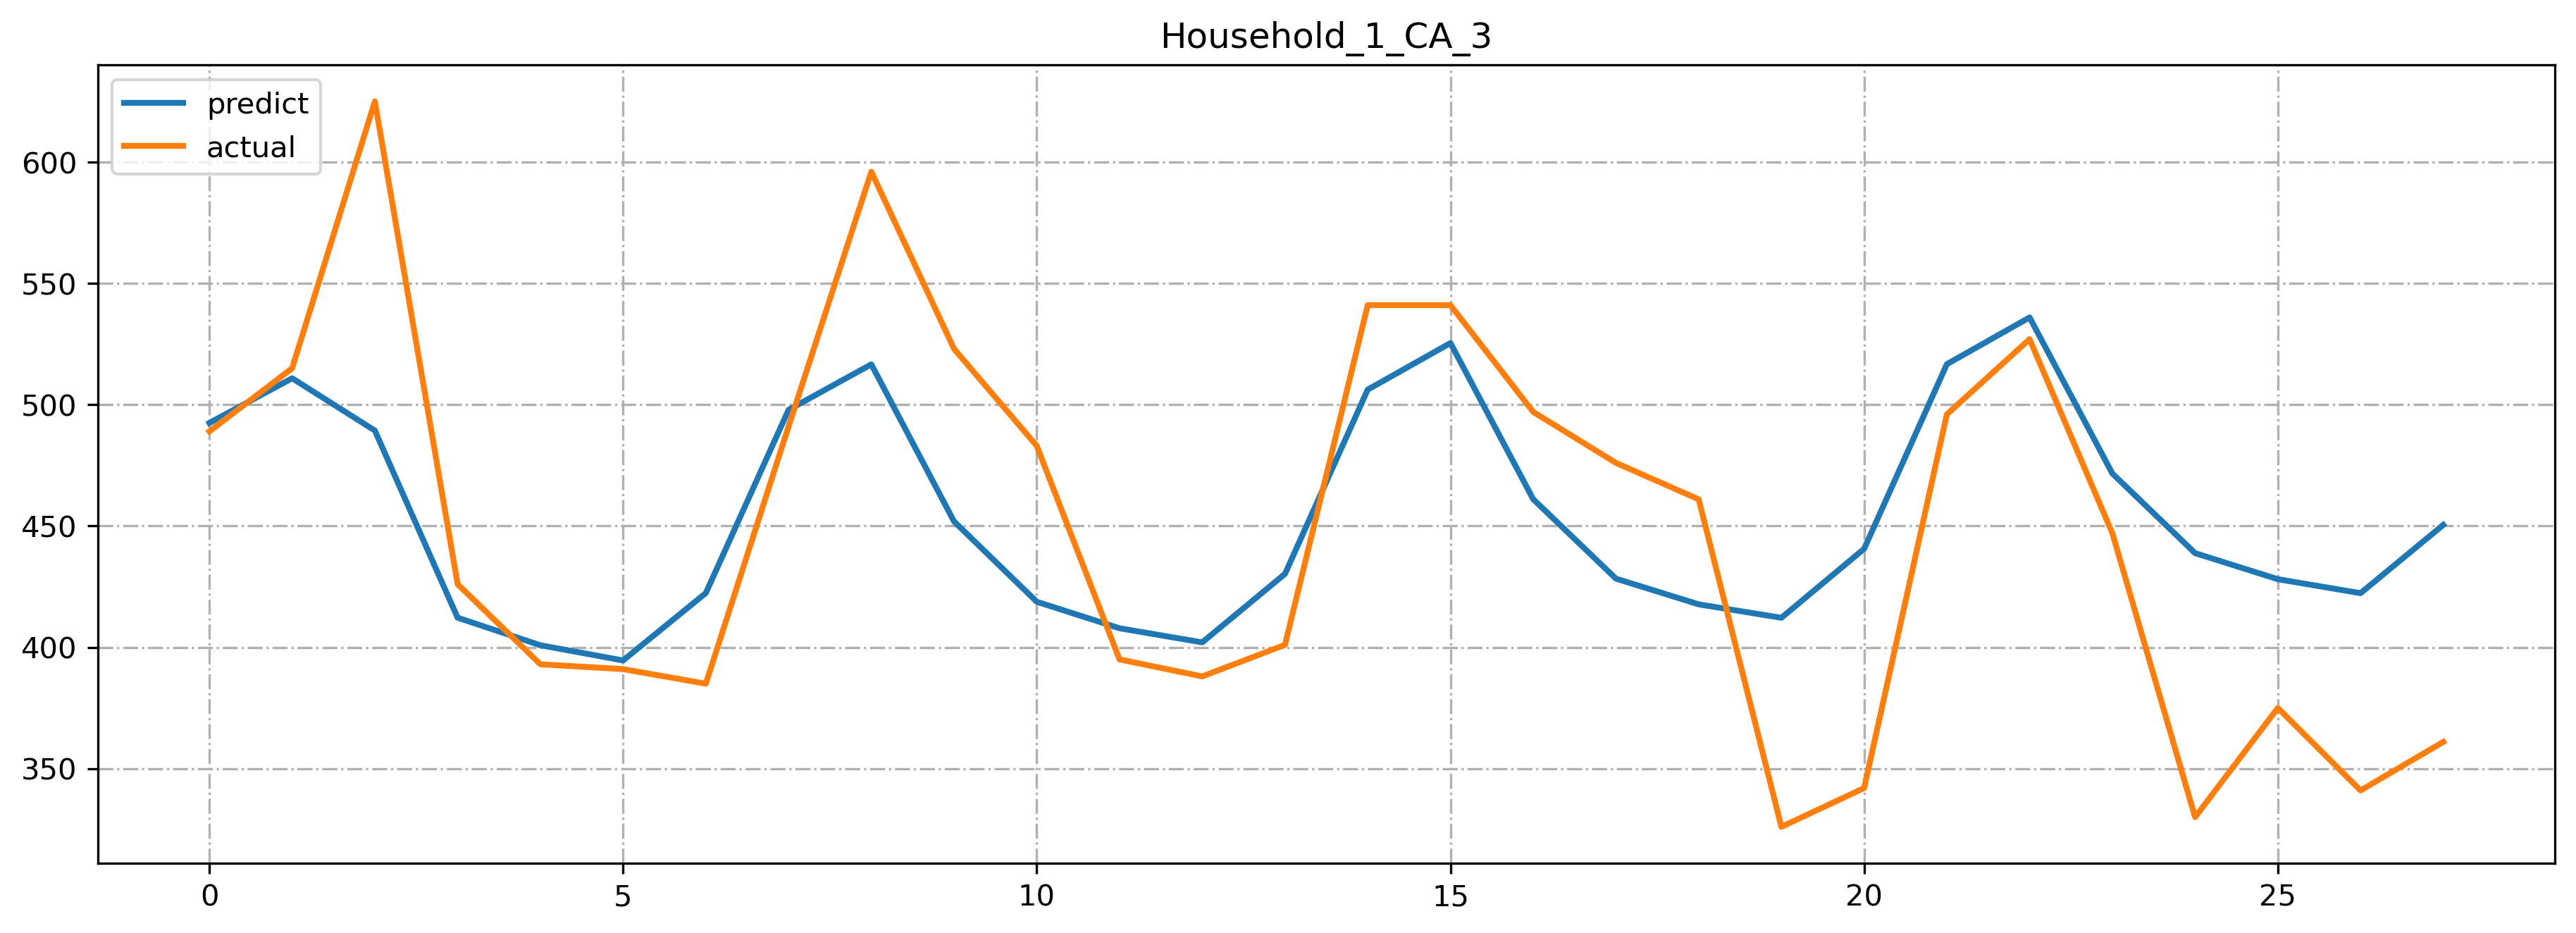

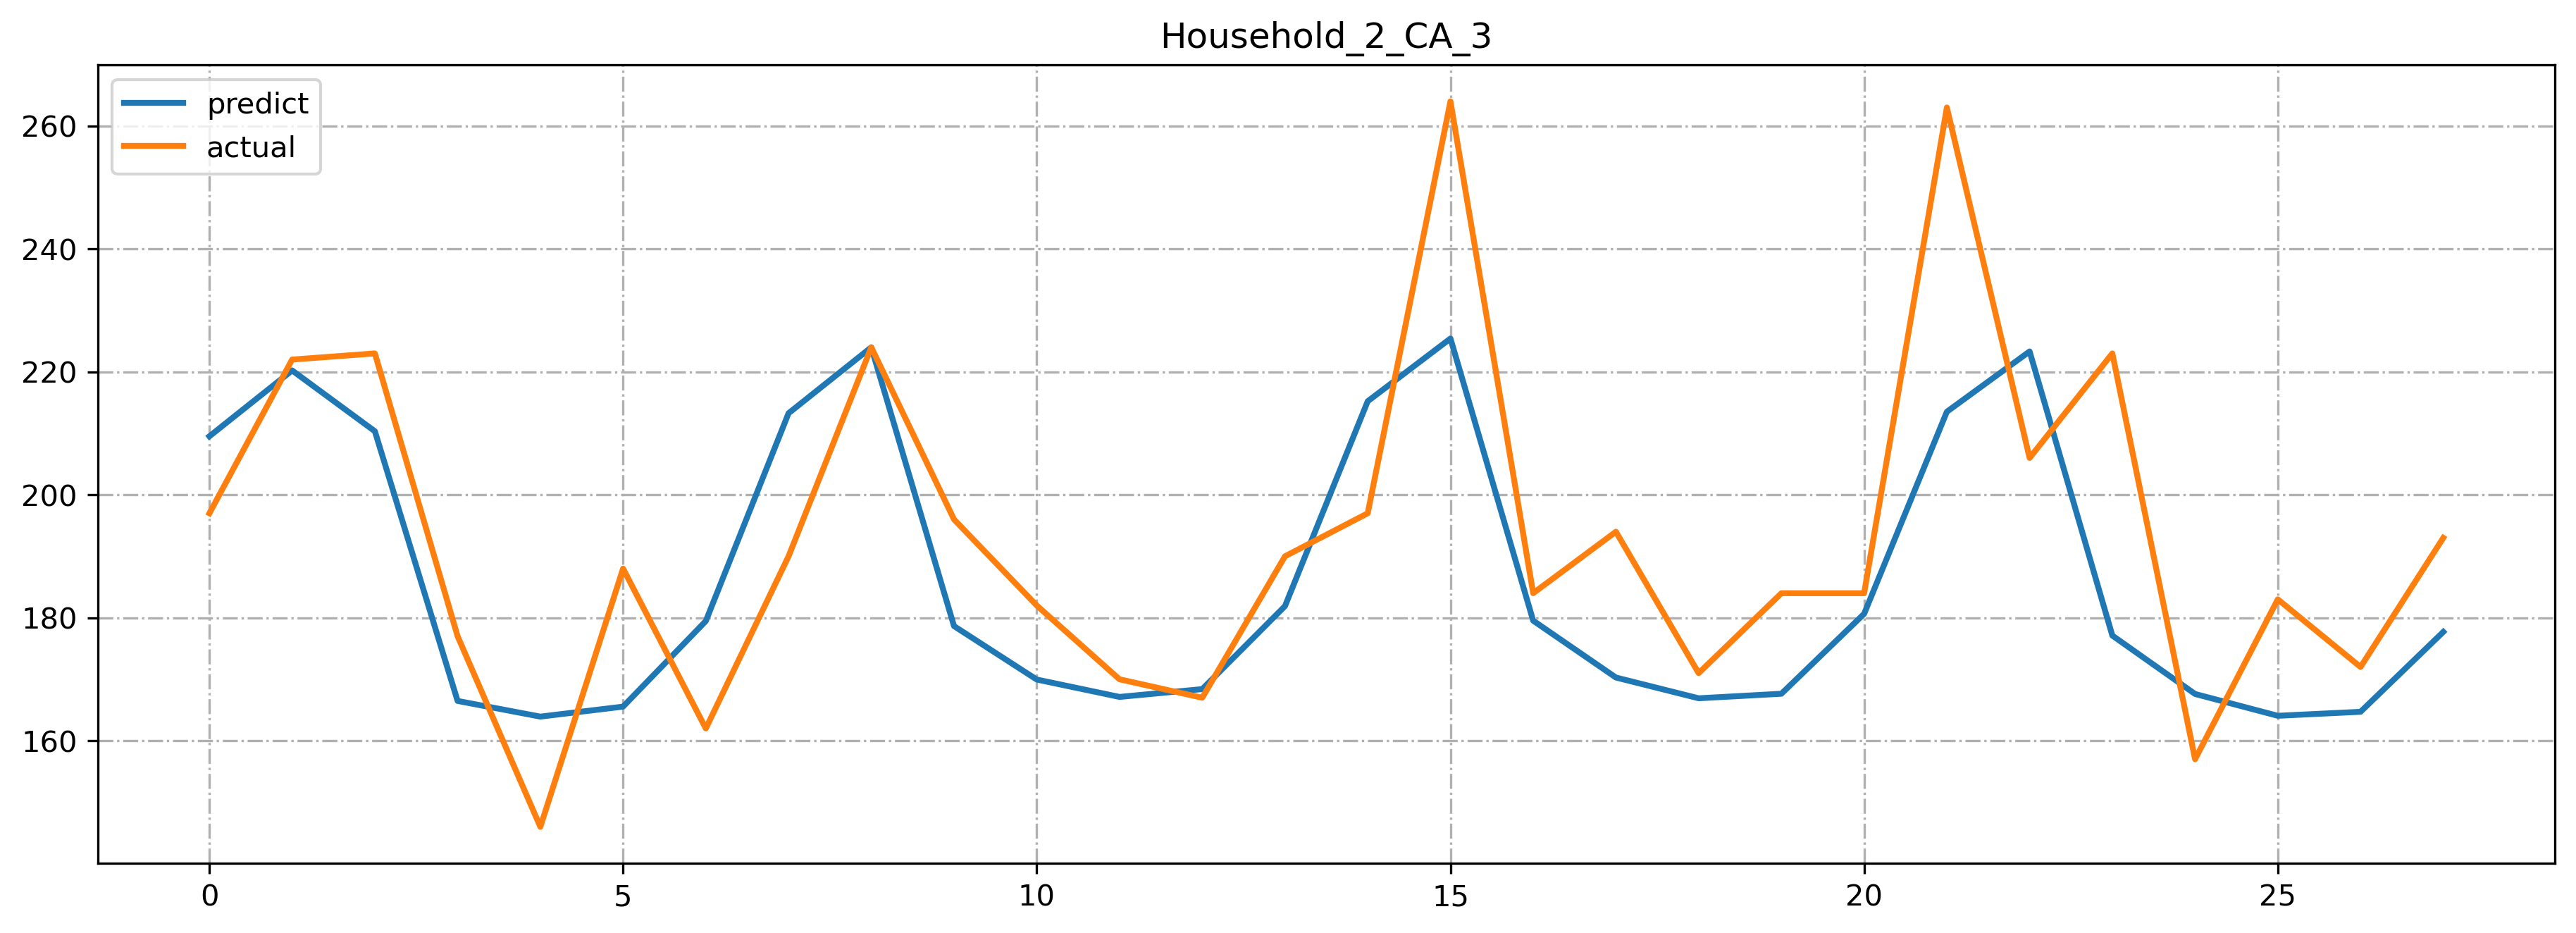

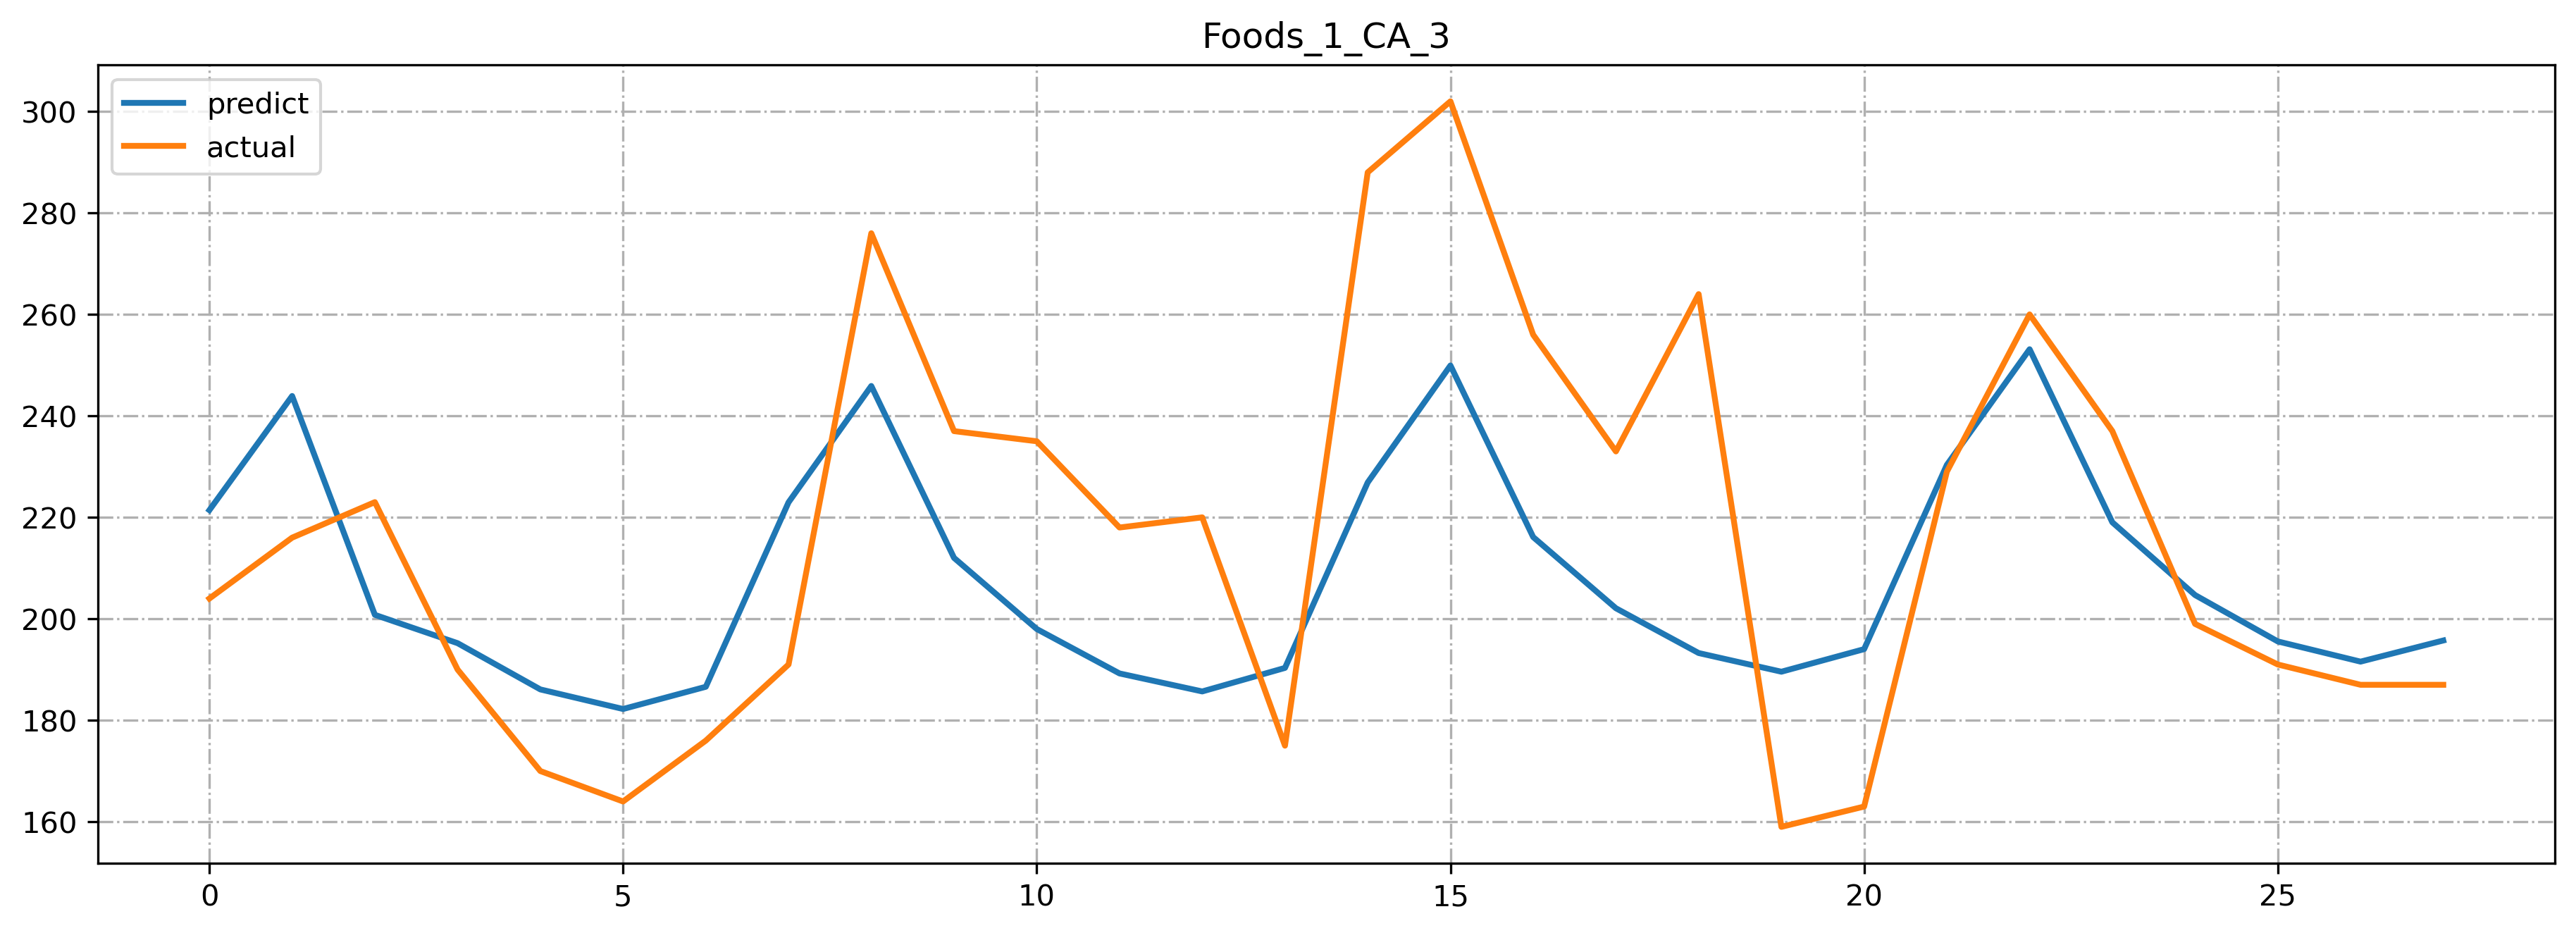

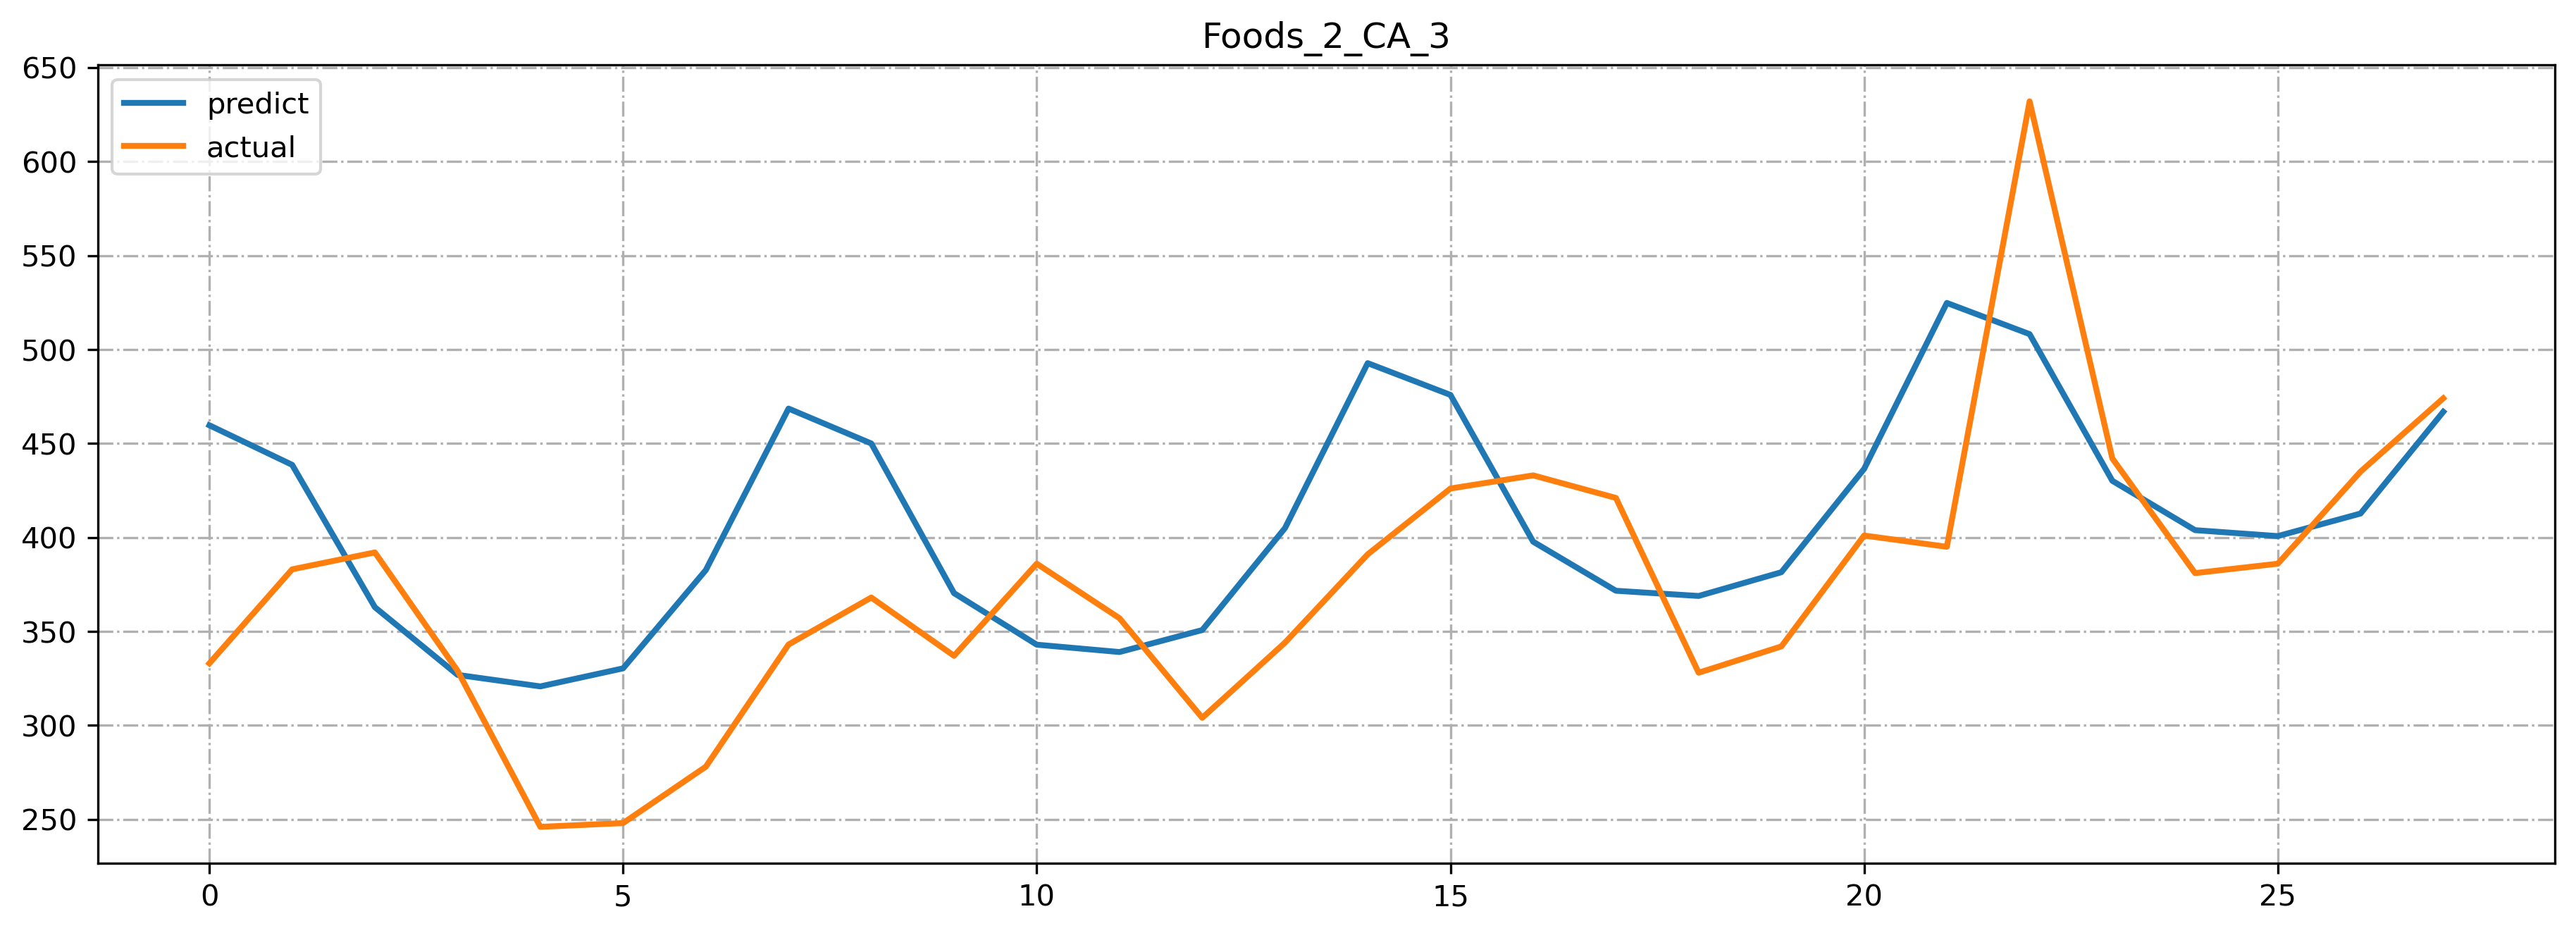

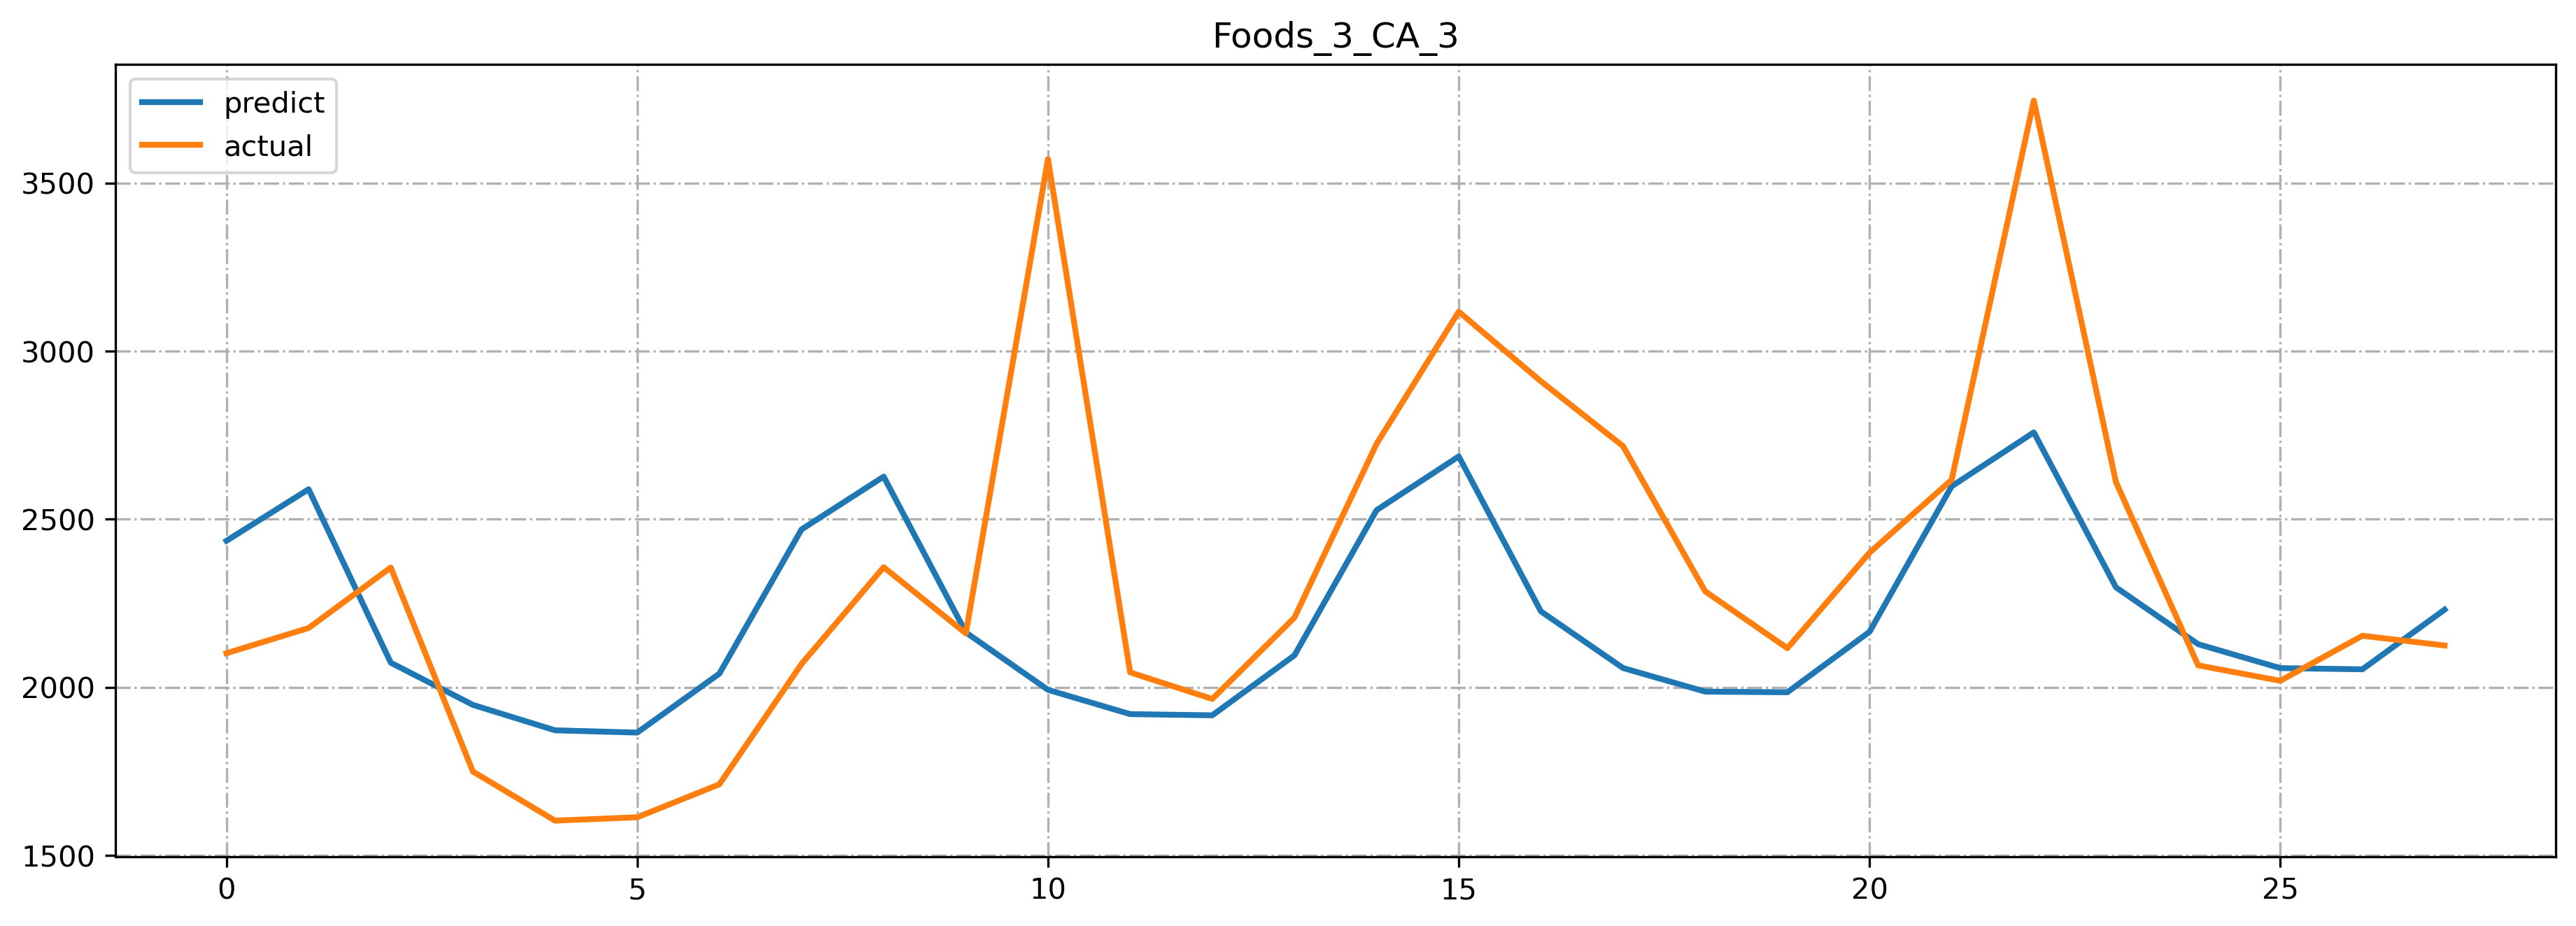

In [18]:
#plot the predict the values and actual values

for i in range(len(y_hat_total.columns)-1):
    predict = y_hat_total.iloc[:,i+1].tail(28).values
    actual = test.iloc[:28,i+1].values
    x = [x for x in range(28)]
    fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
    ax.plot(x, predict, linewidth=2.0,label = "predict")
    ax.plot(x, actual, linewidth=2.0,label = "actual")
    ax.legend(loc=2);
    ax.set_title(test.columns[i+1])
    #plt.ylim((0, 450000))
    plt.grid(linestyle='-.')
    plt.show()

In [20]:
#calculate the root mean square error for each variables forecast

from sklearn.metrics import mean_squared_error
from math import sqrt

error_total = []
for i in range(len(y_hat_total.columns)-1):
    predict = y_hat_total.iloc[:,i+1].tail(28).values
    actual = test.iloc[:28,i+1].values
    rmse = sqrt(mean_squared_error(actual, predict))
    error_total.append(rmse)


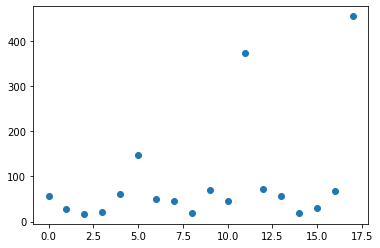

In [21]:
#plot error for each variables
plt.scatter(x = range(len(error_total)), y = error_total)